<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_simpson.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(simpson-notebook)=
# Paradosso di Simpson

Nel presente capitolo approfondiremo il [paradosso di Simpson](https://it.wikipedia.org/wiki/Paradosso_di_Simpson), fenomeno che mette in risalto una significativa sfida epistemologica nel campo della psicologia. Tale paradosso prende forma quando una relazione negativa tra due variabili, chiaramente riconoscibile all'interno di un gruppo isolato, si altera, scompare o, sorprendentemente, si inverte una volta che i dati di più gruppi vengono uniti ed esaminati congiuntamente.

Questo fenomeno riveste un'importanza cruciale in psicologia, poiché apre un dibattito fondamentale sull'applicabilità dei risultati della ricerca psicologica all'individuo. In particolare, ci costringe a riflettere sulla legittimità dell'estrapolare conclusioni destinate all'individuo a partire da dati analizzati a livello aggregato, ovvero di popolazione.

La questione centrale della discussione diviene, dunque: è davvero possibile che i risultati ottenuti dalla ricerca psicologica, che si basa in larga parte sull'analisi di dati aggregati, siano applicabili a livello individuale, o trovano corrispondenza solo in un contesto più ampio, vale a dire quello della popolazione?

Nel corso del capitolo, illustreremo come l'interpretazione di analisi condotte su dati aggregati possa generare una visione distorta delle reali dinamiche a livello individuale. Esploreremo inoltre le potenzialità offerte dall'impiego di modelli gerarchici, che permettono di tener conto delle differenze individuali, garantendo risultati validi sia sul piano della collettività che su quello dell'individuo singolo.

Durante l'analisi, procederemo con una progressione di modelli di regressione lineare, cominciando dalla forma più semplice per arrivare alla variante gerarchica. 

Nel corso del capitolo, ci addentreremo in diverse tematiche chiave, tra cui:
- L'impiego dei contenitori `pm.Data` per semplificare le predizioni a posteriori relative a differenti valori di $x$ utilizzando lo stesso modello;
- L'attribuzione di dimensioni specifiche agli array nei modelli mediante l'opzione `coords`, una pratica che prevede l'utilizzo di `xarray` ed è particolarmente vantaggiosa nei modelli gerarchici o a più livelli.

Precisiamo che il codice usato in questo capitolo è tratto del tutorial sul paradosso di Simpson disponibile sul sito ufficiale di PyMC.

## Preparazione del Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
import seaborn as sns
import arviz as az
import xarray as xr
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Capire il Paradosso di Simpson

Nel 1899, Karl Pearson e collaboratori illustrarono un paradosso statistico nelle associazioni marginali e parziali tra variabili continue. Successivamente, nel 1903, Udny Yule delineò "la teoria dell'associazione degli attributi in statistica", svelando l'esistenza di un paradosso associativo con variabili categoriche. In un articolo pubblicato nel 1951, Edward H. Simpson descrisse il fenomeno dell'inversione dei risultati. Nel 1972 Colin R. Blyth coniò il termine "Paradosso di Simpson". 

Il paradosso di Simpson può manifestarsi in qualsiasi insieme di dati, indipendentemente dalle  dimensioni dei dati e dalla tipologia di variabili contenute, evidenziando come l'analisi di dati aggregati possa talvolta offrire una visione distorta delle relazioni effettive presenti nel dataset.

Nella tabella successiva è presentato un esempio originale del Paradosso di Simpson mediante una tavola di contingenza 2×2 {cite:p}`simpson1951interpretation`: il tipo di associazione per l'intera popolazione (𝑁=52) si inverte al livello delle sottopopolazioni di uomini e donne.

|         | **Popolazione 𝑁=52** | **Uomini (M) = 20** | **Donne (F) = 32**  |
|---------|--------------------|--------------------|---------------------|
|         | **Successo (S)**     | **Successo**        | **Successo**         |
|         | **Insucceso (¬𝑆)**   | **Insucceso**      | **Insucceso**       |
|         | **Tasso di successo %** | **Tasso di successo %** | **Tasso di successo %**  |
| **T**   | 20                 | 8                  | 12                  |
|         | 20                 | 5                  | 15                  |
|         | 50%                | ≈61%               | ≈44%                |
| **¬𝑇** | 6                  | 4                  | 2                   |
|         | 6                  | 3                  | 3                   |
|         | 50%                | ≈57%               | ≈40%                | 

Nella tabella sopra, "T" e "¬T" rappresentano due differenti condizioni o gruppi, mentre "Successo" e "Insucceso" rappresentano due possibili esiti. I valori numerici indicano il numero di individui che hanno ottenuto ciascun esito in ciascun gruppo, e i tassi di successo sono calcolati come la percentuale di successi rispetto al totale degli esiti per ciascun gruppo.

Il dataset delle ammissioni all'UC Berkeley è un esempio classico del paradosso di Simpson {cite:p}`bickel1975sex`. Questo dataset includeva 12763 candidati alla laurea (maschi e femmine) all'UC Berkeley nell'autunno del 1973. Il dataset è stato fornito dai ricercatori dell'UC Berkeley per indagare su possibili casi di pregiudizio di genere nelle ammissioni. Nel dataset, la percentuale di ammissione per le femmine è inferiore rispetto a quella per i maschi quando i dati sono aggregati; tuttavia, considerando separatamente ogni corso di laurea, le percentuali di ammissione delle femmine superano quelle dei maschi nella maggior parte dei sottogruppi.

**Tabella 2. Presenza del Paradosso di Simpson: un caso di studio basato sul dataset delle ammissioni all'UC-Berkeley (autunno 1973).**

|       | Domande di ammissione | Ammessi | Rifiutati | Percentuale di ammissione |
|-------|------------------------|---------|-----------|---------------------------|
| Uomini | 8442                   | 3738    | 4704      | 44%                       |
| Donne  | 4321                   | 1494    | 2827      | 35%                       |

Per comprendere appieno la situazione e le dinamiche sottostanti, è fondamentale non solo considerare i dati aggregati, ma anche esaminare i dati a livello di dipartimento, così come illustrato nella Tabella 3.

Tabella 3. Dataset delle ammissioni all'UC-Berkeley (autunno 1973): Percentuale del tasso di accettazione di uomini e donne in diversi dipartimenti.
| Genere | Dipartimento A | Dipartimento B | Dipartimento C | Dipartimento D | Dipartimento E | Dipartimento F |
|--------|----------------|----------------|----------------|----------------|----------------|----------------|
| Uomini | 62.06%         | 63.04%         | 36.92%         | 33.09%         | 27.75%         | 5.90%          |
| Donne  | 82.41%         | 68.00%         | 34.06%         | 34.93%         | 23.92%         | 7.04%          |

I dati aggregati presentati nella Tabella 2 mostrano un significativo bias a favore dei candidati maschi; tuttavia, i dati relativi a ciascun dipartimento, forniti nella Tabella 3, rivelano una situazione opposta, con un bias a favore delle candidate femmine. 

Un secondo esempio famoso è fornito da uno studio di {cite:t}`radelet1991choosing`. In tale studio è stata esaminata l'influenza della razza dell'accusato e della vittima sulle decisioni relative all'applicazione della pena di morte in Florida dal 1976 al 1987. Consideriamo inizialmente solo la razza dell'accusato. Dai dati raccolti su 674 individui accusati di omicidio plurimo, emerge che la propensione verso l'applicazione della pena di morte sembra essere più elevata per gli accusati bianchi rispetto a quelli afro-americani. Infatti, calcolando il rapporto delle quote (odds ratio, OR) a partire dai dati forniti:

$$
\text{odds}_{\text{bianchi}} = \frac{53}{430} = 0.1233, \quad \text{odds}_{\text{afro-americani}} = \frac{15}{176} = 0.0852, \quad OR = \frac{176 \times 53}{15 \times 430} = 1.4462
$$

risulta che gli accusati bianchi hanno una propensione all'applicazione della pena di morte 1.45 volte superiore rispetto agli afro-americani.

Tuttavia, l'analisi fornisce la conclusione opposta quando si incorpora anche la razza della vittima come ulteriore variabile. Introducendo questo elemento, troviamo che l'odds ratio relativo alla razza dell'accusato cambia notevolmente: $\widehat{OR}_{\text{accusato}} = 0.42$. Questo significa che, controllando per la razza della vittima, la propensione all'applicazione della pena di morte è in realtà minore per gli accusati bianchi rispetto a quelli afro-americani. In termini più espliciti, la probabilità di ricevere la pena di morte è 2.38 volte maggiore per gli accusati afro-americani rispetto agli accusati bianchi.

L'analisi di questi dati mette in luce un altro chiaro esempio del paradosso di Simpson, dove l'associazione tra due variabili può cambiare direzione o addirittura scomparire quando si tiene conto di una terza variabile, in questo caso, la razza della vittima. Inizialmente, osservando solo l'associazione tra la razza dell'accusato e l'applicazione della pena di morte, sembrava che gli accusati bianchi avessero una maggiore propensione ad essere condannati a morte, con un rapporto delle quote (OR) di 1.4462. Tuttavia, questo risultato è stato capovolto quando abbiamo introdotto una variabile aggiuntiva, la razza della vittima, nel modello. Controllando per questa variabile, abbiamo trovato che la propensione all'applicazione della pena di morte era in realtà 2.38 volte maggiore per gli accusati afro-americani rispetto a quelli bianchi.

Questo ci porta a concludere che la razza dell'accusato da sola non è un indicatore sufficiente per prevedere l'applicazione della pena di morte; piuttosto, è l'interazione tra la razza dell'accusato e quella della vittima a determinare l'esito. Anche questo esempio sottolinea dunque l'importanza critica di esaminare attentamente tutte le variabili rilevanti in un'analisi statistica per evitare conclusioni errate. 

### Psicologia: una scienza individuale o di popolazione?

Il Paradosso di Simpson rappresenta un nodo cruciale nella comprensione e nell'interpretazione delle analisi dei dati condotte frequentemente dagli psicologi durante la valutazione dei risultati sperimentali. Tradizionalmente, i corsi introduttivi di psicologia pongono l'individuo al centro dell'analisi, delineandolo come l'unità di analisi primaria. Nonostante ciò, sia gli strumenti didattici sia le metodologie di ricerca applicate nella pratica tendono a focalizzarsi maggiormente sulle medie di gruppo piuttosto che sull'individuo singolo.

Questo orientamento verso l'analisi aggregata introduce una sfida significativa, specialmente alla luce del Paradosso di Simpson. Infatti, abbiamo osservato come il paradosso si manifesti quando l'associazione tra due variabili, evidente a livello di popolazione, subisca un'inversione o persino scompaia quando la popolazione è divisa in sottogruppi diversi.

La ricerca psicologica, quindi, si trova a fronteggiare un dilemma metodologico: una relazione identificata a livello di popolazione non assicura la persistenza di tale relazione all'interno di tutti i sottogruppi presenti, soprattutto quando questi sottogruppi rappresentano gli individui. Sebbene esista una consapevolezza diffusa dell'unicità degli individui, nella prassi, le differenze individuali vengono frequentemente ridotte a semplici varianze o errori, venendo percepite come interferenze indesiderate all'analisi.

Di qui emerge una questione di fondo: può la psicologia ancora definirsi una scienza centrata sull'individuo o, piuttosto, dovrebbe essere vista come una scienza della popolazione, più vicina all'epidemiologia nella sua approccio?

Per navigare efficacemente attraverso le complessità portate dal Paradosso di Simpson e questioni correlate, diventa imprescindibile adottare modelli analitici che rispettino la strutturazione stratificata dei dati, evitando di appiattire le individualità in un aggregato di medie non rappresentative. Nonostante la tendenza attuale sia quella di focalizzarsi sulle medie del gruppo, è vitale accogliere e superare le sfide proposte dal Paradosso di Simpson, per preservare l'integrità delle inferenze sia a livello di popolazione che individuale.

Alla luce di tale complessità, è emera la necessità di rivedere l'approccio all'analisi dei dati in psicologia, assegnando un rilievo preminente alle differenze individuali. Questo non solo in omaggio all'unicità di ciascun individuo ma anche per affinare la validità e la pertinenza delle deduzioni tratte dalla ricerca psicologica.

Nel proseguo di questo capitolo, ci dedicheremo all'esplorazione di come i modelli gerarchici siano in grado di incorporare le differenze individuali, prevenendo le distorsioni interpretative scaturite dal paradosso di Simpson. Tale approccio permette di delineare un quadro analitico più preciso ed affidabile, che presti la dovuta attenzione alle singole peculiarità individuali.

## Generare i dati

Genereremo i dati seguendo le indicazioni fornite nel codice disponibile in questa [pagina web](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html), dove è presentato un tutorial dedicato al paradosso di Simpson. Mentre nelle sezioni precedenti ci siamo concentrati sul paradosso di Simpson in contesti che coinvolgono variabili qualitative, nella prossima parte della discussione ci focalizzeremo su un caso in cui il paradosso riguarda la relazione lineare tra due variabili continue, \(x\) e \(y\), in una situazione in cui i dati sono stratificati in diversi gruppi.

In [3]:
def generate():
    group_list = ["one", "two", "three", "four", "five"]
    trials_per_group = 20
    group_intercepts = rng.normal(0, 1, len(group_list))
    group_slopes = np.ones(len(group_list)) * -0.5
    group_mx = group_intercepts * 2
    group = np.repeat(group_list, trials_per_group)
    subject = np.concatenate(
        [np.ones(trials_per_group) * i for i in np.arange(len(group_list))]
    ).astype(int)
    intercept = np.repeat(group_intercepts, trials_per_group)
    slope = np.repeat(group_slopes, trials_per_group)
    mx = np.repeat(group_mx, trials_per_group)
    x = rng.normal(mx, 1)
    y = rng.normal(intercept + (x - mx) * slope, 1)
    data = pd.DataFrame({"group": group, "group_idx": subject, "x": x, "y": y})
    return data, group_list

Generiamo i dati insieme ad una lista che contiene i nomi dei cinque gruppi.

In [4]:
data, group_list = generate()

In [5]:
print(group_list)

['one', 'two', 'three', 'four', 'five']


In [6]:
display(data)

,group,group_idx,x,y
0,one,0,-0.692745,0.750369
1,one,0,0.737275,-0.709225
2,one,0,0.293192,0.123805
3,one,0,0.592633,1.153426
4,one,0,-0.243610,-0.996081
...,...,...,...,...
95,five,4,-4.280233,-1.424379
96,five,4,-2.602842,-1.193167
97,five,4,-4.258334,-1.682318
98,five,4,-3.164555,-1.675854


Creiamo uno scatterplot con i 5 gruppi di dati.

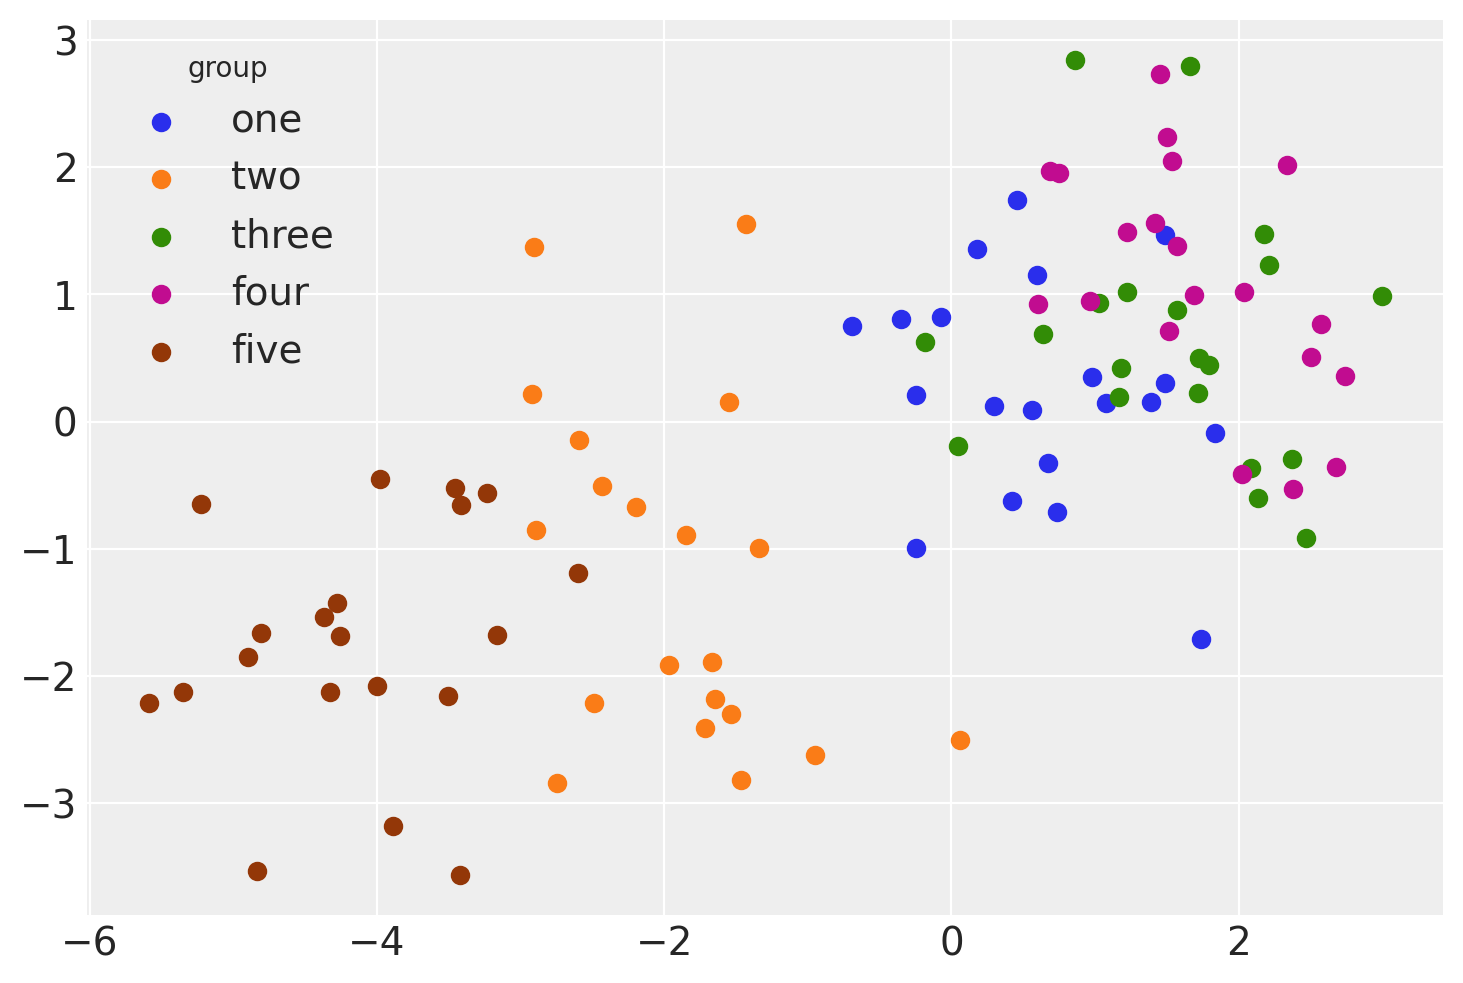

In [7]:
for i, group in enumerate(group_list):
    plt.scatter(
        data.x[data.group_idx == i],
        data.y[data.group_idx == i],
        color=f"C{i}",
        label=f"{group}",
    )
plt.legend(title="group");

1. `for i, group in enumerate(group_list):`
   
   In questa linea, stiamo iniziando un ciclo for che itera attraverso ogni elemento in `group_list`. La funzione `enumerate` è utilizzata per ottenere sia l'indice (`i`) che il valore (`group`) per ogni iterazione.

2. `plt.scatter(...)`

   Dentro il ciclo for, chiamiamo la funzione `scatter` da `plt` (che è una abbreviazione comune per `matplotlib.pyplot`) per creare un grafico a dispersione. Vediamo i dettagli di ciascun parametro che abbiamo passato alla funzione `scatter`:

   - `data.x[data.group_idx == i]`
   
     Qui stiamo selezionando tutti i valori dalla colonna `'x'` del DataFrame `data` dove i valori nella colonna `'group_idx'` sono uguali a `i`. Questo è fatto utilizzando il filtraggio booleano.

   - `data.y[data.group_idx == i]`
   
     Simile al parametro x, qui stiamo selezionando tutti i valori dalla colonna `'y'` del DataFrame `data` dove i valori nella colonna `'group_idx'` sono uguali a `i`.

   - `color=f"C{i}"`

     Qui stiamo assegnando un colore unico a ciascun gruppo di punti nel grafico a dispersione. `f"C{i}"` è una stringa f che inserisce il valore di `i` (l'indice corrente nel ciclo) nella stringa, creando stringhe come `'C0'`, `'C1'`, ..., che vengono utilizzate per specificare i colori in matplotlib.

   - `label=f"{group}"`

     Qui stiamo assegnando un'etichetta a ciascun gruppo di punti, che verrà utilizzata nella legenda del grafico. Stiamo usando il valore corrente di `group` (il nome del gruppo corrente) come etichetta.

3. `plt.legend(title="group");`

   Dopo la fine del ciclo for, chiamiamo la funzione `legend` da `plt` per aggiungere una legenda al grafico. La legenda utilizzerà le etichette e i colori che abbiamo specificato nelle chiamate precedenti a `scatter` per creare una legenda che mostra quale colore corrisponde a quale gruppo. Abbiamo anche specificato un titolo per la legenda, che è `"group"`.

## Modello 1: regressione lineare bivariata

Iniziamo con il modello più semplice - la regressione lineare semplice, che raggruppa tutti i dati e non ha alcuna conoscenza della struttura di gruppo/multilivello dei dati.

### Definizione del modello

In [8]:
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.MutableData("x", data.x, dims="obs_id")
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")

```python
with pm.Model() as linear_regression:
```
Qui iniziamo a definire il nostro modello PyMC3, creando un contesto per il nostro modello chiamato `linear_regression`.

```python
    sigma = pm.HalfCauchy("sigma", beta=2)
```
In questa linea, stiamo definendo una variabile casuale `sigma` che seguirà una distribuzione Half-Cauchy con un parametro `beta` impostato a 2. Questa variabile rappresenta la deviazione standard dei residui del modello.

```python
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
```
Qui stiamo definendo due variabili casuali, `β0` e `β1`, che rappresentano rispettivamente l'intercetta e la pendenza della linea di regressione. Entrambe sono assunte seguire una distribuzione normale con media 0 e deviazione standard 5.

```python
    x = pm.MutableData("x", data.x, dims="obs_id")
```
In questa linea, stiamo definendo un contenitore di dati mutabile per le variabili indipendenti (o predittori) del nostro modello, basato sul vettore `data.x`.

```python
    μ = pm.Deterministic("μ", β0 + β1 * x, dims="obs_id")
```
Qui, definiamo una variabile deterministica `μ` che rappresenta il valore atteso della variabile dipendente in funzione delle variabili indipendenti e dei parametri della regressione.

```python
    pm.Normal("y", mu=μ, sigma=sigma, observed=data.y, dims="obs_id")
```
Infine, definiamo la distribuzione delle variabili dipendenti (o risposte) assumendo che seguano una distribuzione normale con media `μ` e deviazione standard `sigma`. Impostiamo i dati osservati a `data.y`.

In sintesi, questo codice sta impostando un modello di regressione lineare semplice con PyMC, in cui si cerca di prevedere la variabile dipendente `y` in base alla variabile indipendente `x`, con parametri di regressione `β0` e `β1`, e una deviazione standard dei residui `sigma`. 

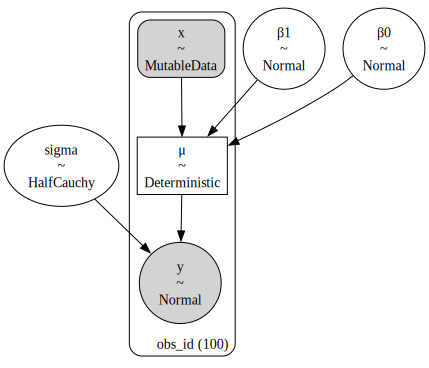

In [9]:
pm.model_to_graphviz(linear_regression)

### Campionamento

Una volta definito il modello, è possibile usare il sampling MCMC per ottenere stime dei parametri del modello.

In [10]:
with linear_regression:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.059333


Sampling...


  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

Running chain 0:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1290.66it/s]


Running chain 1: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1291.85it/s]


Running chain 2: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1292.97it/s]


Running chain 3: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1294.60it/s]


Sampling time = 0:00:01.778145


Transforming variables...


Transformation time = 0:00:00.104785


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

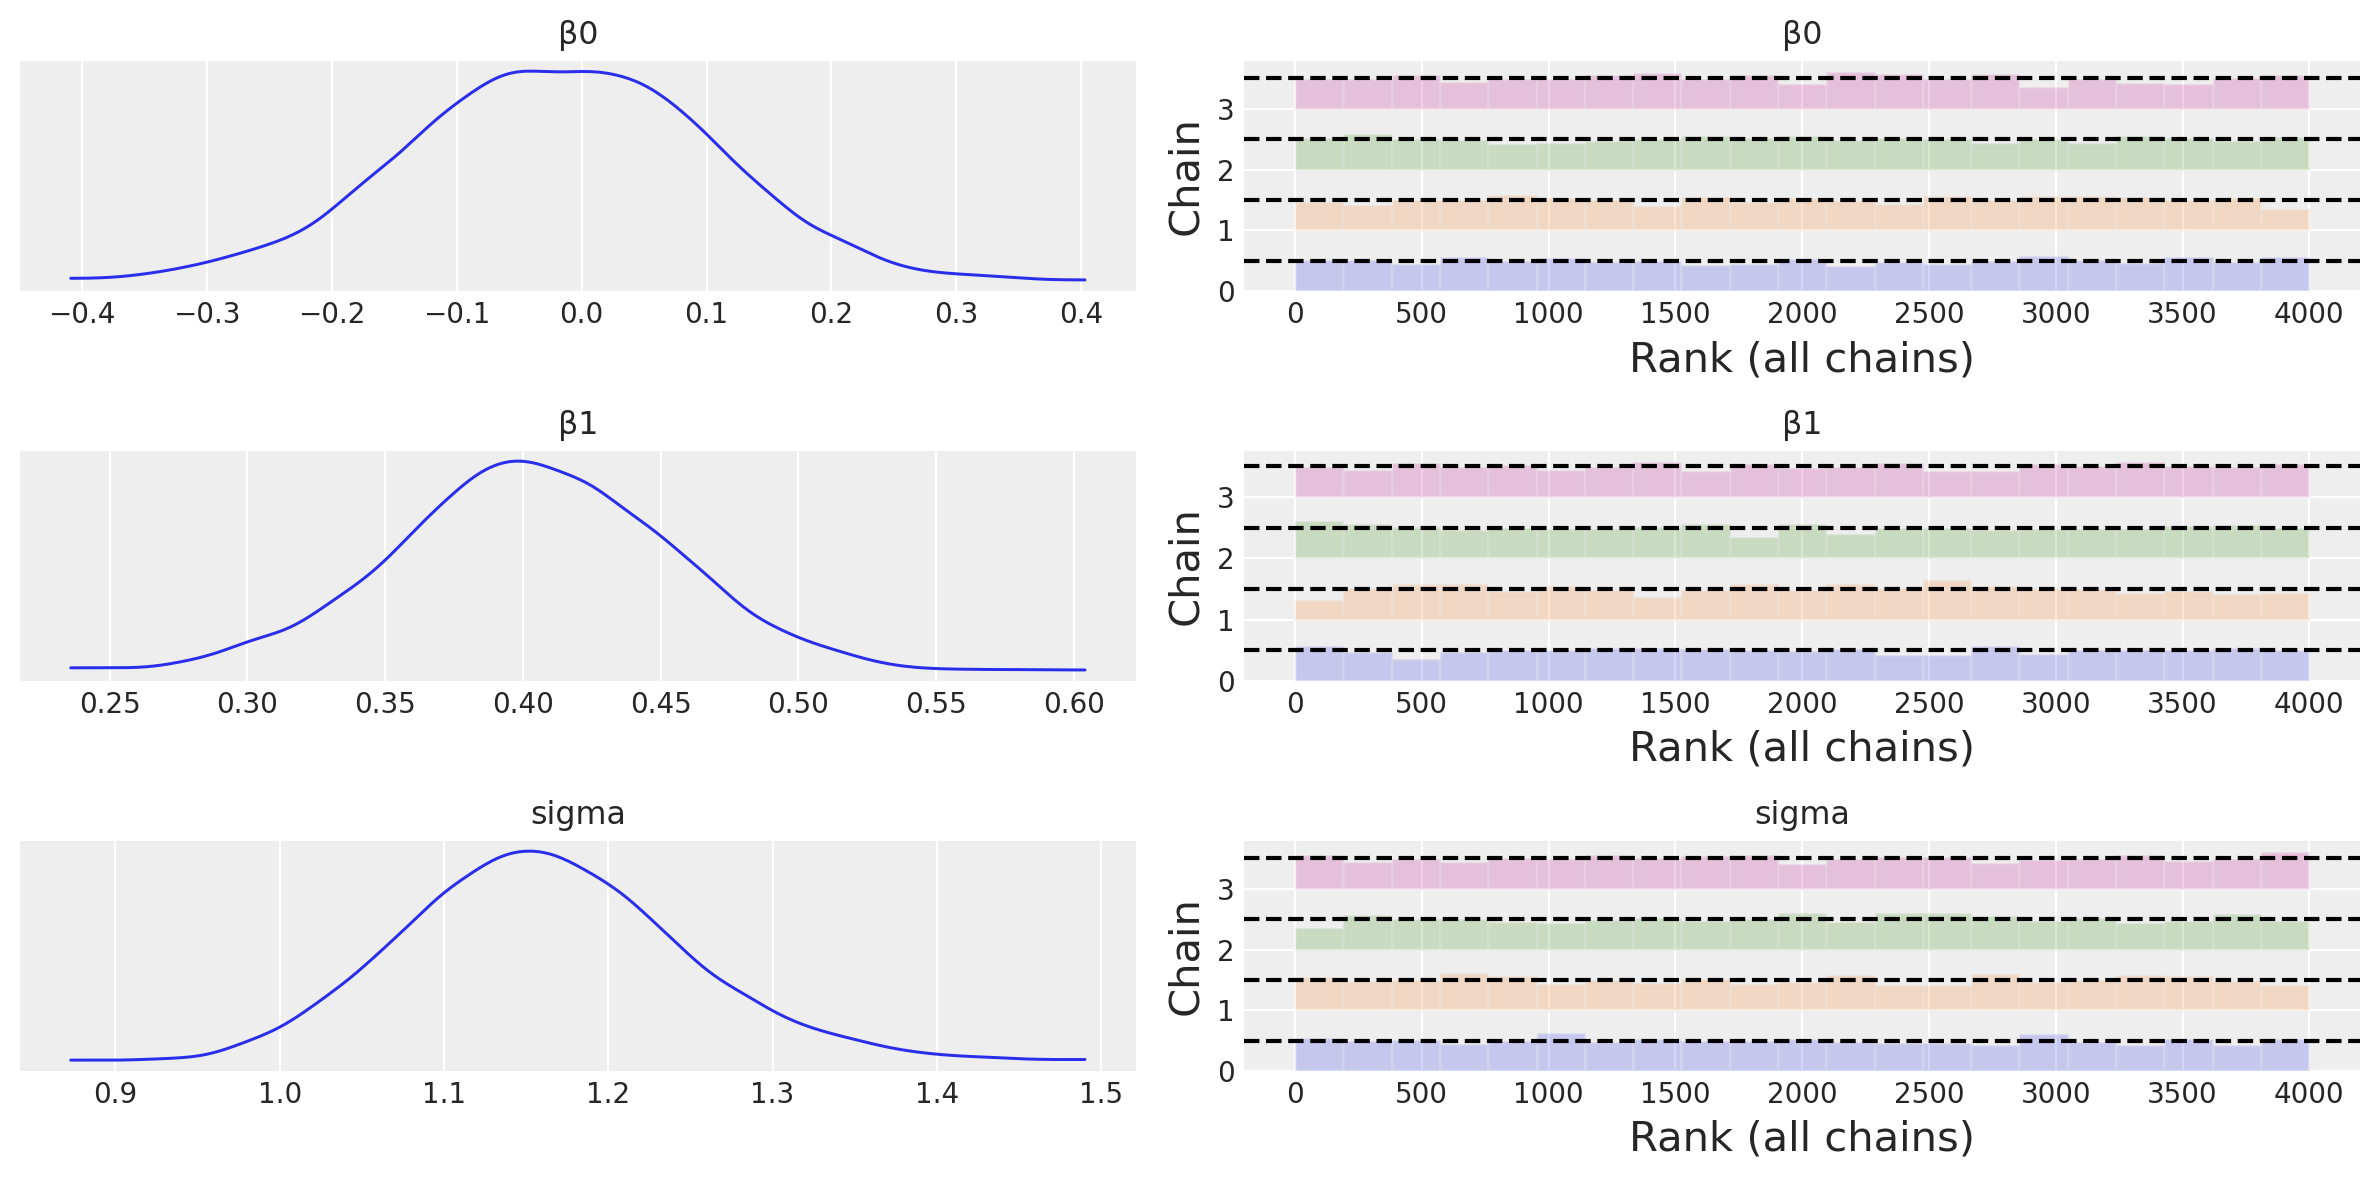

In [11]:
az.plot_trace(
    idata,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    combined=True,
    divergences="bottom",
)
plt.tight_layout()

### Visualizzazione

Per ottenere una comprensione più profonda del nostro modello, decidiamo di eseguire una predizione a posteriori utilizzando un set di valori `x` che copre l'intervallo osservato dei nostri dati. Creiamo un array `xi` contenente 20 punti che spaziano linearmente dal minimo al massimo valore osservato di `x`.

Entrando nel contesto del nostro modello di regressione lineare, aggiorniamo il dataset del modello con questo nuovo array `xi` utilizzando `pm.set_data`. Successivamente, eseguiamo l'inferenza predittiva a posteriori utilizzando `pm.sample_posterior_predictive`, specificando che desideriamo ottenere campioni a posteriori per le variabili `y` e `μ`. Questo processo ci permette di ottenere una distribuzione di valori predetti y e μ, riflettendo non solo le incertezze nei parametri del modello ma anche la variabilità intrinseca nei dati.

Estendiamo il nostro contenitore di dati a posteriori `idata` con queste nuove predizioni, consentendoci così di analizzare e visualizzare la distribuzione a posteriori dei valori predetti in un secondo momento, fornendo una visione ricca dell'incertezza predittiva del nostro modello.

In [12]:
# posterior prediction for these x values
xi = np.linspace(data.x.min(), data.x.max(), 20)

# do posterior predictive inference
with linear_regression:
    pm.set_data({"x": xi})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["y", "μ"]))

Sampling: [y]


Una volta ottenuto l'oggetto `idata` con le caratteristiche descritte sopra, visualizziamo la soluzoine del modello che abbiamo definito usando il codice fornito nella [pagina web](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-simpsons-paradox.html).

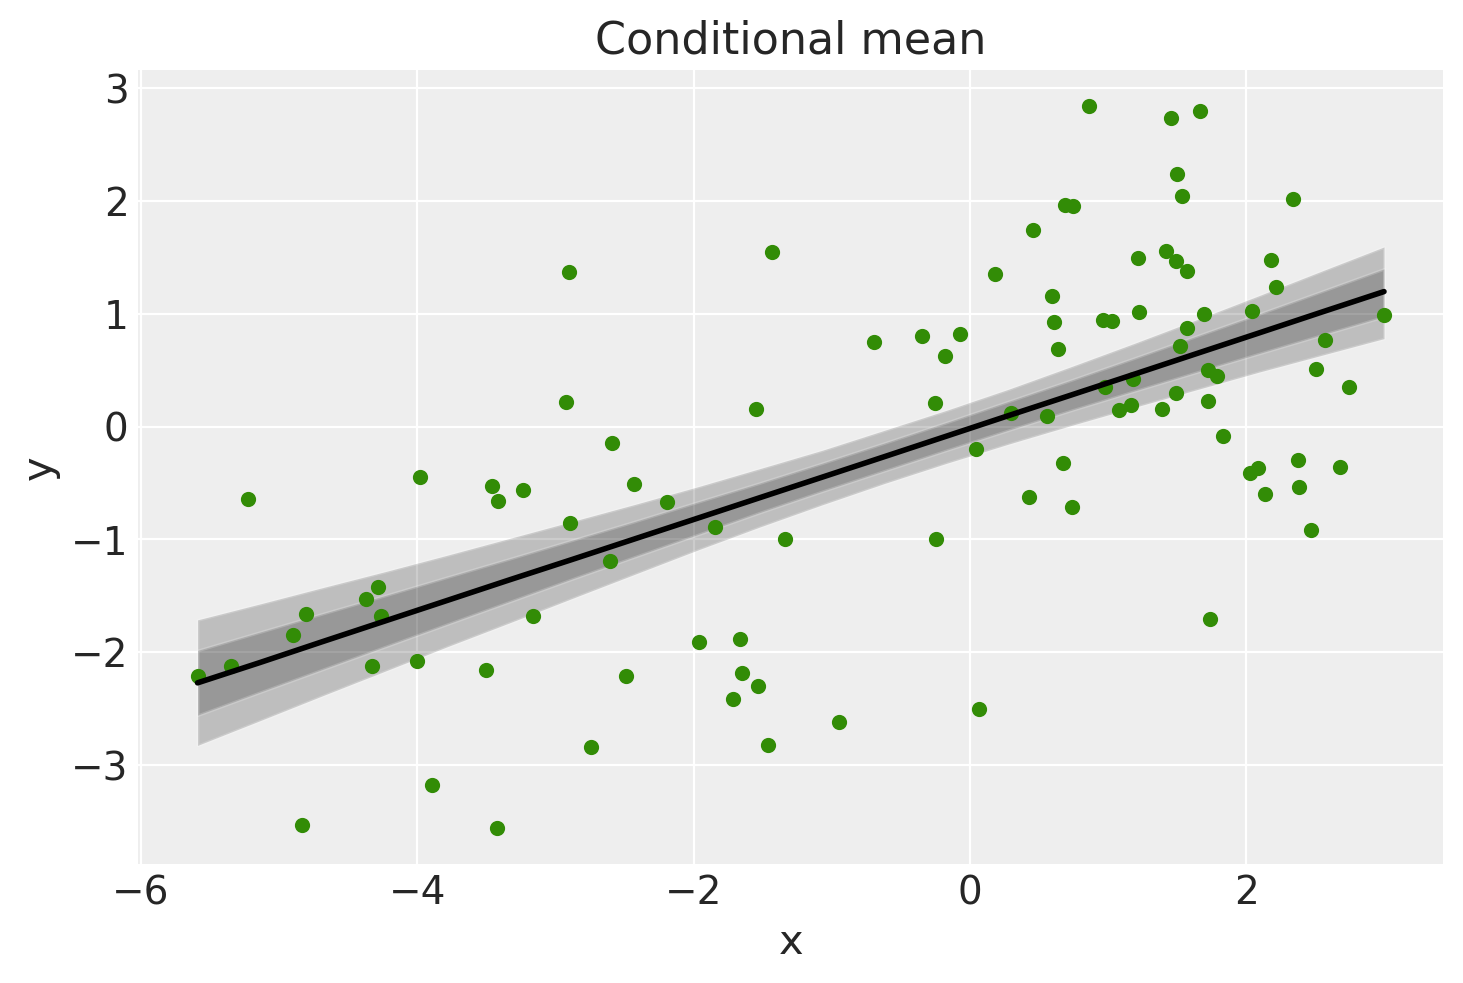

In [13]:
post = az.extract(idata)

xi = xr.DataArray(np.linspace(np.min(data['x']), np.max(data['x']), 20), dims=["x_plot"])
y = post.β0 + post.β1 * xi
region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")

fig, ax = plt.subplots(1, 1)

ax.fill_between(
    xi, region.sel(quantile=0.025), region.sel(quantile=0.975), alpha=0.2, color="k", edgecolor="w"
)
ax.fill_between(
    xi, region.sel(quantile=0.15), region.sel(quantile=0.85), alpha=0.2, color="k", edgecolor="w"
)

# Plotting the conditional mean
ax.plot(xi, region.sel(quantile=0.5), "k", linewidth=2)

# Plotting the data points
ax.scatter(data['x'], data['y'], color='C2', s=20, label='Data points')

# Formatting
ax.set(xlabel="x", ylabel="y", title="Conditional mean")

plt.show()  # Add this line to actually show the plot

Per approfondire la comprensione del codice precedente, analizziamo la seguente versione semplificata.

In [14]:
beta_0 = idata.posterior.β0.mean().values
print(beta_0)

-0.01807673461918448


In [15]:
beta_1 = idata.posterior.β1.mean().values
print(beta_1)

0.4032049043686827


In [16]:
xi = np.linspace(np.min(data["x"]), np.max(data["x"]), 20)
xi

array([-5.58940481, -5.13754963, -4.68569444, -4.23383926, -3.78198407,
       -3.33012889, -2.8782737 , -2.42641852, -1.97456333, -1.52270815,
       -1.07085296, -0.61899778, -0.16714259,  0.28471259,  0.73656778,
        1.18842296,  1.64027815,  2.09213333,  2.54398852,  2.9958437 ])

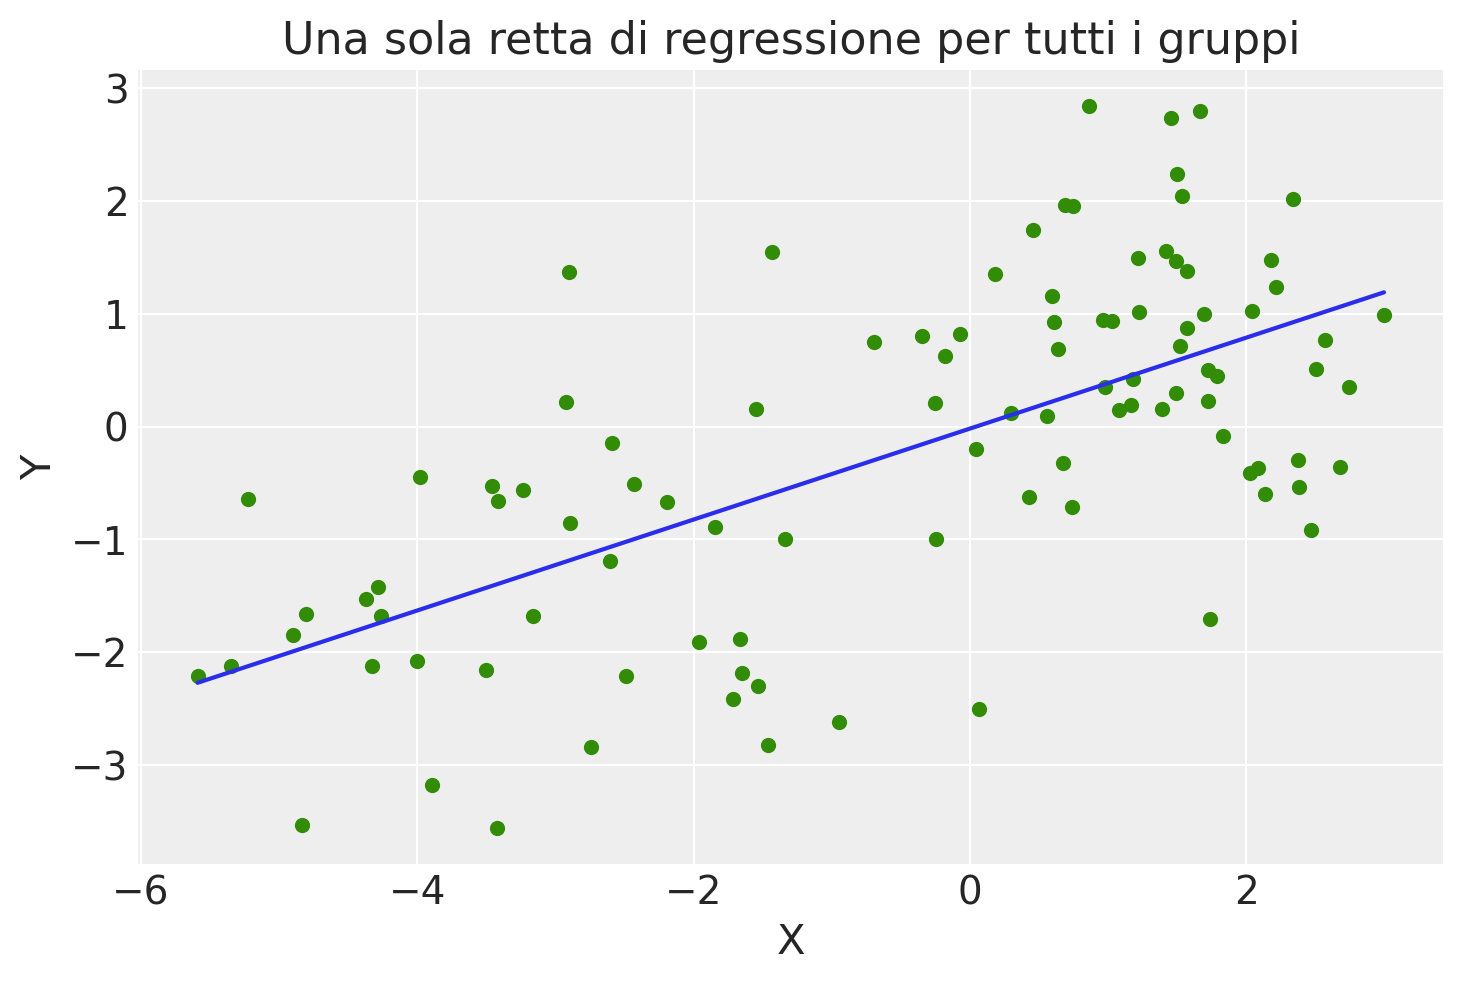

In [17]:
# Genera la linea di regressione utilizzando l'equazione della retta
y_pred = beta_0 + beta_1 * xi

# Visualizza la linea di regressione
plt.plot(xi, y_pred)
plt.scatter(data['x'], data['y'], color='C2', s=20)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Una sola retta di regressione per tutti i gruppi')
plt.show()

In [18]:
az.summary(idata, var_names="β1")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β1,0.403,0.05,0.307,0.496,0.001,0.001,3341.0,3038.0,1.0


L'analisi dei dati aggregati mostra la presenza di un'associazione positiva tra le variabili: β1 = 0.236, 94% CI [0.126, 0.351].

## Modello 2: Modello con pendenze e intercette indipendenti

Useremo gli stessi dati in questa seconda analisi, ma questa volta utilizzeremo la nostra conoscenza che i dati provengono da gruppi diversi. Più specificatamente, adatteremo regressioni indipendenti ai dati all'interno di ogni gruppo.

In [19]:
coords = {"group": group_list}

with pm.Model(coords=coords) as ind_slope_intercept:
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
    β0 = pm.Normal("β0", 0, sigma=5, dims="group")
    β1 = pm.Normal("β1", 0, sigma=5, dims="group")
    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

1. Definizione delle coordinate
```python
coords = {"group": group_list}
```
Qui, viene creato un dizionario che associa un nome ("group") a una lista di gruppi (`group_list`). Questo verrà usato per specificare le dimensioni del modello.

2. Creazione del modello con PyMC3
```python
with pm.Model(coords=coords) as ind_slope_intercept:
```
Inizia la definizione del modello PyMC3, dove `coords=coords` specifica le coordinate che verranno usate nel modello.

3. Definizione dei prior
```python
sigma = pm.HalfCauchy("sigma", beta=2, dims="group")
β0 = pm.Normal("β0", 0, sigma=5, dims="group")
β1 = pm.Normal("β1", 0, sigma=5, dims="group")
```
In questa sezione, vengono definiti i prior per i parametri del modello. Sia `β0` che `β1` sono definiti come distribuzioni normali con una media di 0 e una deviazione standard di 5. La `sigma`, che rappresenta l'errore standard delle osservazioni, segue una distribuzione HalfCauchy con un parametro `beta` di 2. Questi prior sono definiti separatamente per ogni gruppo, come indicato da `dims="group"`.

4. Specificazione dei dati
```python
x = pm.MutableData("x", data.x, dims="obs_id")
g = pm.MutableData("g", data.group_idx, dims="obs_id")
```
I dati vengono inseriti nel modello tramite oggetti `MutableData`, che permettono di cambiare i dati in seguito senza dover definire un nuovo modello. Qui, `data.x` rappresenta la variabile indipendente e `data.group_idx` rappresenta gli indici dei gruppi.

5. Definizione del modello lineare
```python
μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
```
Qui, viene definito il modello lineare. La media (`μ`) viene calcolata come la somma dell'intercetta (`β0`) e la pendenza (`β1`) moltiplicata per la variabile indipendente (`x`). Questo viene fatto separatamente per ogni gruppo, come indicato dall'indexing con `g`.

6. Definizione della likelihood
```python
pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")
```
Infine, viene definita la funzione di likelihood, che è una distribuzione normale con una media (`mu`) definita dal modello lineare e una deviazione standard (`sigma`) specifica per ogni gruppo. Il parametro `observed=data.y` indica che stiamo adattando il modello ai dati osservati `data.y`. La specifica `dims="obs_id"` indica che questa parte del modello opera su una dimensione che rappresenta ciascuna osservazione individuale nel nostro set di dati.

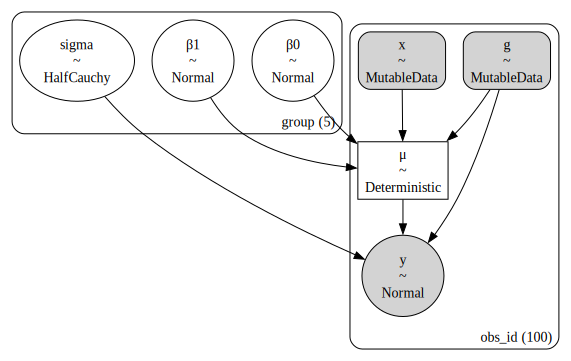

In [20]:
pm.model_to_graphviz(ind_slope_intercept)

### Campionamento

In [21]:
with ind_slope_intercept:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:07.428001


Sampling...


  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                | 0/2000 [00:01<?, ?it/s]

Running chain 3:  55%|███████████████████████████▌                      | 1100/2000 [00:01<00:00, 10866.87it/s]

Running chain 2:  50%|█████████████████████████▌                         | 1000/2000 [00:01<00:00, 9530.58it/s]

Running chain 0:  50%|█████████████████████████▌                         | 1000/2000 [00:01<00:00, 9260.46it/s]

Running chain 1:  55%|███████████████████████████▌                      | 1100/2000 [00:01<00:00, 10029.68it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1087.72it/s]


Running chain 1: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1088.20it/s]


Running chain 2: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1088.89it/s]


Running chain 3: 100%|███████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1089.58it/s]

Sampling time = 0:00:01.943811


Transforming variables...


Transformation time = 0:00:00.098457


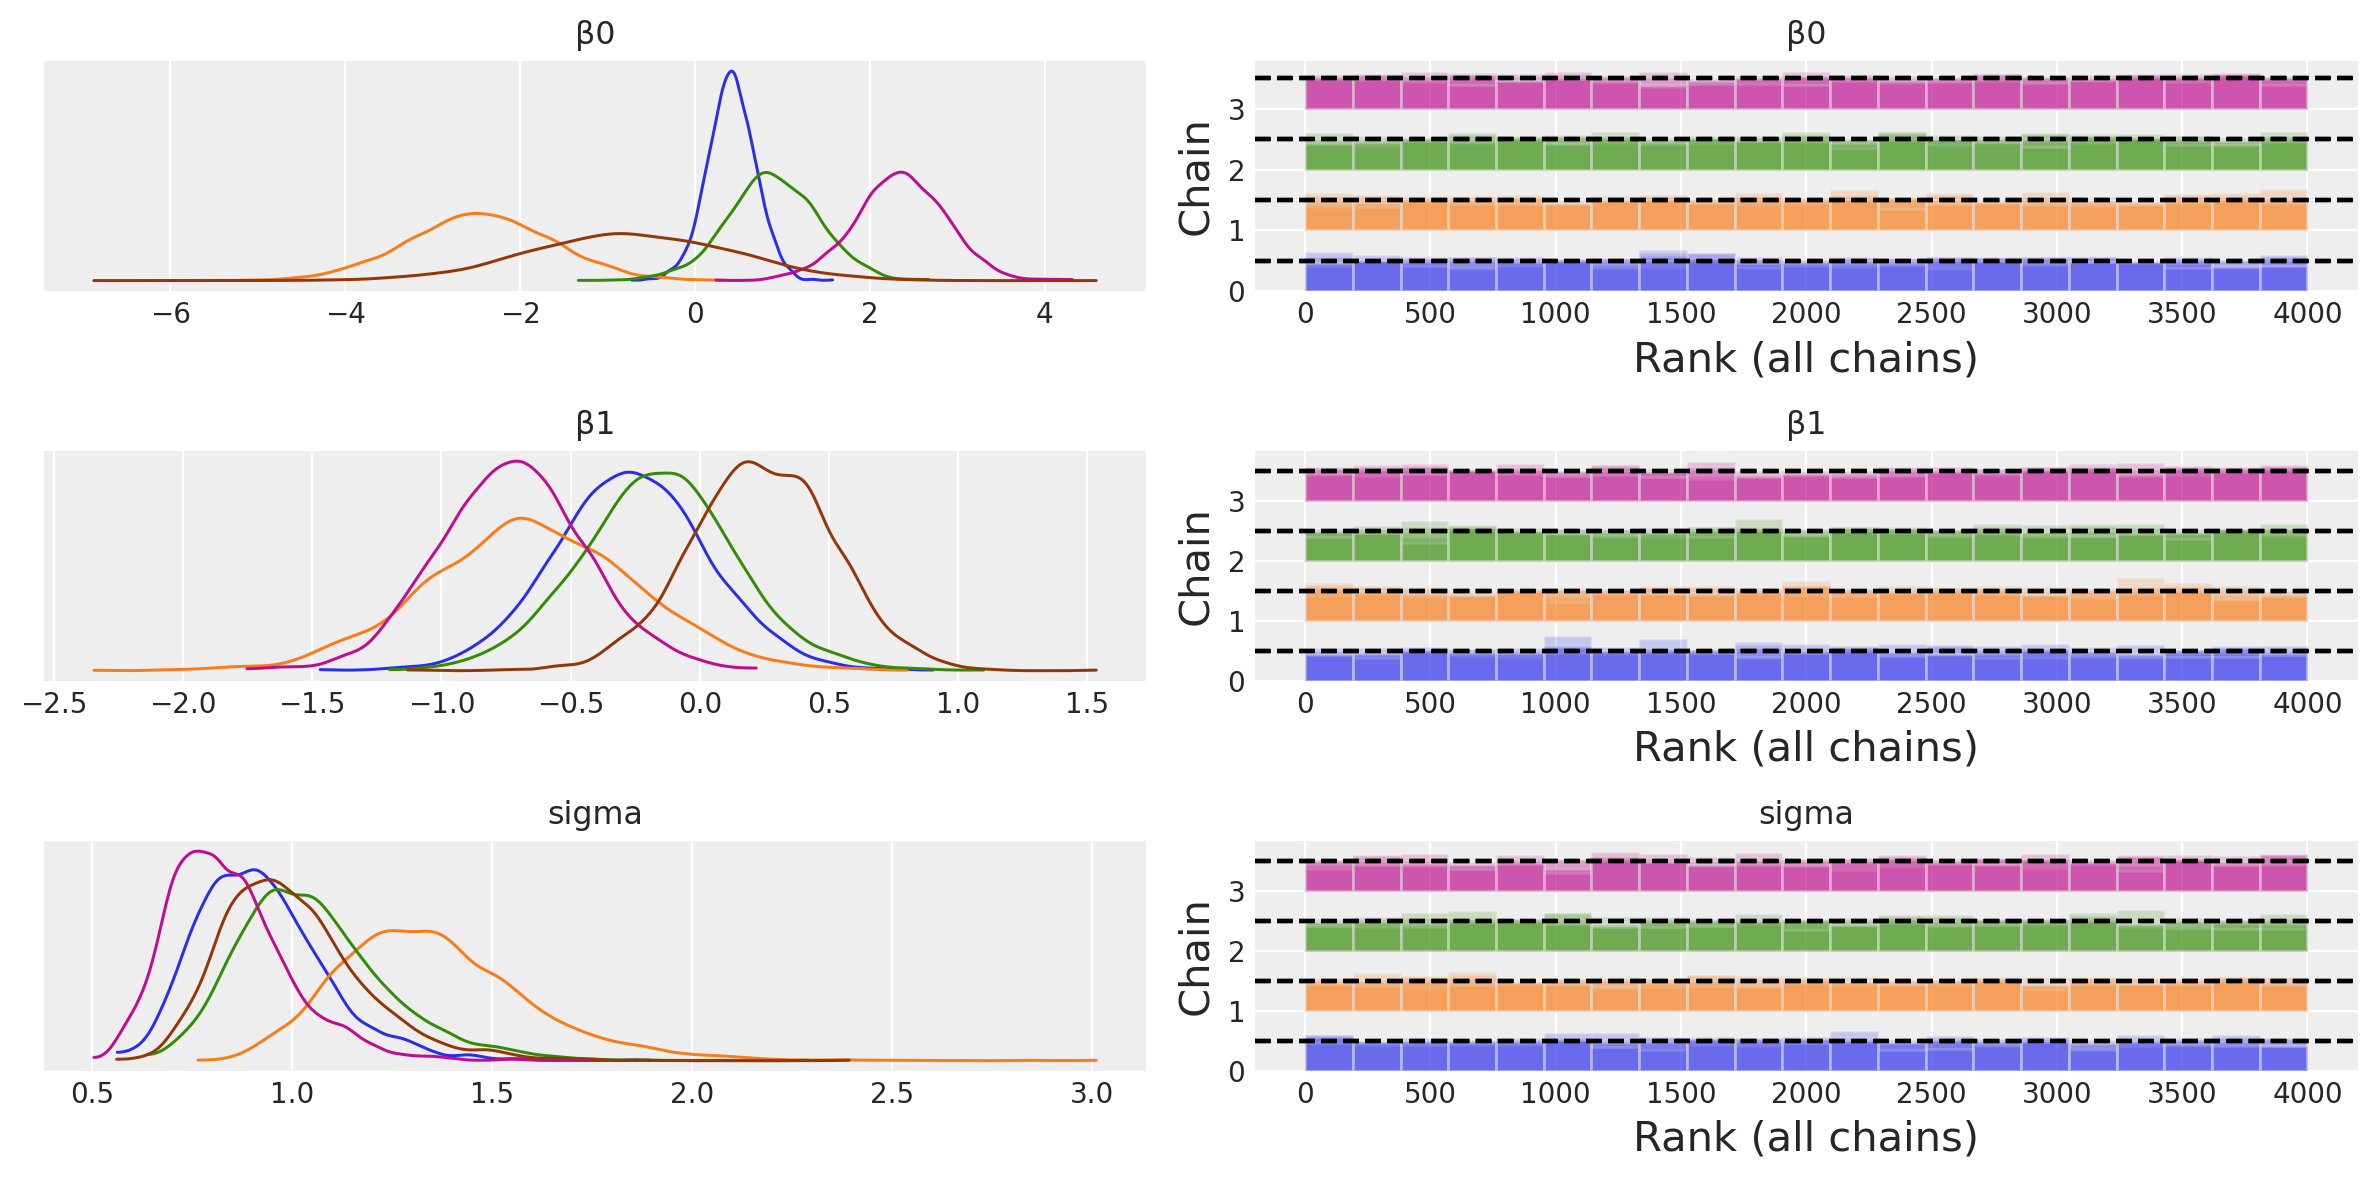

In [22]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

### Visualizzazione

In [23]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with ind_slope_intercept:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


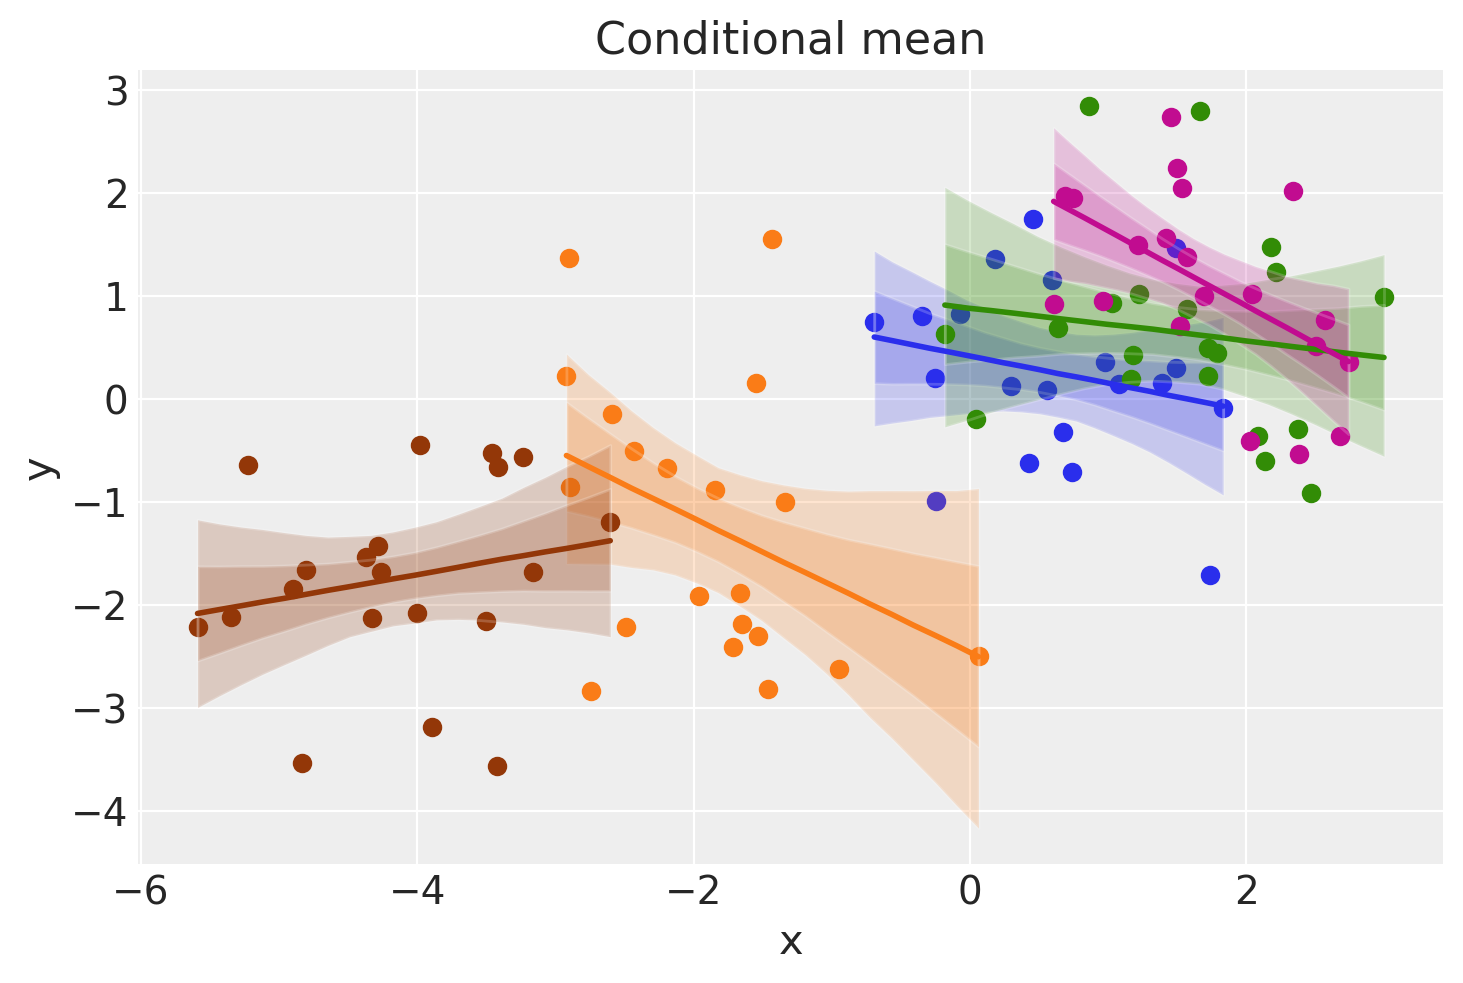

In [24]:
def get_ppy_for_group(group_list, group):
    """Get posterior predictive outcomes for observations from a given group"""
    return idata.posterior_predictive.y.data[:, :, group_list == group]


fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


A differenza del semplice modello di regressione (Modello 1), quando modelliamo a livello di gruppo possiamo vedere che ora le prove indicano una relazione negativa tra $x$ e $y$.

## Modello 3: Regressione gerarchica

Possiamo andare oltre il Modello 2 e incorporare ancora più conoscenze riguardo alla struttura dei nostri dati. Invece di trattare ogni gruppo come completamente indipendente, possiamo utilizzare la nostra conoscenza che questi gruppi provengono da una distribuzione a livello di popolazione. Questi sono talvolta chiamati iperparametri.

In un certo senso, questo passaggio dal Modello 2 al Modello 3 può essere visto come l'aggiunta di parametri, e quindi l'aumento della complessità del modello. Tuttavia, in un altro senso, aggiungendo questa conoscenza sulla struttura nidificata dei dati fornisce effettivamente un vincolo sullo spazio dei parametri.

```{note}
Questo modello produce dei campioni divergenti, quindi è stato modificato mediante la tecnica della reparametrizzazione. Per maggiori informazioni su questo, si veda il post [Why hierarchical models are awesome, tricky, and Bayesian](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) sul blog di Thomas Wiecki.
```

In [25]:
non_centered = False

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

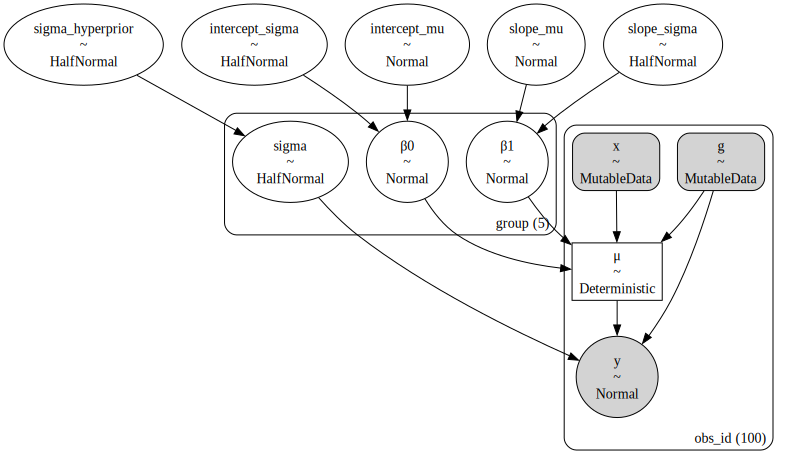

In [26]:
pm.model_to_graphviz(hierarchical)

### Campionamento (senza riparametrizzazione)

In [27]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:02.993695


Sampling...


  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

Running chain 2:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 1:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 1:   5%|██▌                                                 | 300/6000 [00:02<00:02, 2753.84it/s]

Running chain 0:   5%|██▌                                                 | 300/6000 [00:02<00:02, 2592.04it/s]

Running chain 3:   5%|██▌                                                 | 300/6000 [00:02<00:02, 2286.55it/s]

Running chain 2:  10%|█████▏                                              | 600/6000 [00:02<00:01, 4244.70it/s]

Running chain 0:  10%|█████▏                                              | 600/6000 [00:02<00:02, 2546.88it/s]

Running chain 1:  15%|███████▊                                            | 900/6000 [00:02<00:01, 3878.62it/s]

Running chain 2:  20%|██████████▏                                        | 1200/6000 [00:02<00:01, 4295.15it/s]

Running chain 3:  15%|███████▊                                            | 900/6000 [00:02<00:01, 3060.72it/s]

Running chain 0:  20%|██████████▏                                        | 1200/6000 [00:02<00:01, 3340.29it/s]

Running chain 3:  25%|████████████▊                                      | 1500/6000 [00:03<00:01, 3489.79it/s]

Running chain 2:  30%|███████████████▎                                   | 1800/6000 [00:03<00:01, 3674.45it/s]

Running chain 1:  20%|██████████▏                                        | 1200/6000 [00:03<00:02, 2137.56it/s]

Running chain 0:  30%|███████████████▎                                   | 1800/6000 [00:03<00:01, 3625.90it/s]

Running chain 2:  40%|████████████████████▍                              | 2400/6000 [00:03<00:00, 3963.12it/s]

Running chain 3:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:01, 3614.57it/s]

Running chain 0:  40%|████████████████████▍                              | 2400/6000 [00:03<00:00, 3937.13it/s]

Running chain 1:  25%|████████████▊                                      | 1500/6000 [00:03<00:02, 1808.44it/s]

Running chain 2:  50%|█████████████████████████▌                         | 3000/6000 [00:03<00:00, 3418.35it/s]

Running chain 3:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 3135.97it/s]

Running chain 0:  50%|█████████████████████████▌                         | 3000/6000 [00:03<00:00, 3566.76it/s]

Running chain 1:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:01, 2450.90it/s]

Running chain 2:  60%|██████████████████████████████▌                    | 3600/6000 [00:03<00:00, 3397.71it/s]

Running chain 1:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 2885.94it/s]

Running chain 0:  60%|██████████████████████████████▌                    | 3600/6000 [00:03<00:00, 3456.75it/s]

Running chain 3:  55%|████████████████████████████                       | 3300/6000 [00:03<00:00, 2975.70it/s]

Running chain 2:  70%|███████████████████████████████████▋               | 4200/6000 [00:03<00:00, 3517.33it/s]

Running chain 0:  70%|███████████████████████████████████▋               | 4200/6000 [00:03<00:00, 3554.68it/s]

Running chain 1:  55%|████████████████████████████                       | 3300/6000 [00:03<00:00, 3045.68it/s]

Running chain 3:  65%|█████████████████████████████████▏                 | 3900/6000 [00:03<00:00, 3204.45it/s]

Running chain 2:  80%|████████████████████████████████████████▊          | 4800/6000 [00:03<00:00, 3289.15it/s]

Running chain 0:  80%|████████████████████████████████████████▊          | 4800/6000 [00:03<00:00, 3532.61it/s]

Running chain 1:  65%|█████████████████████████████████▏                 | 3900/6000 [00:03<00:00, 3177.99it/s]

Running chain 3:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 3161.99it/s]

Running chain 2:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:04<00:00, 3455.69it/s]

Running chain 0:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:04<00:00, 3566.14it/s]

Running chain 1:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 3148.99it/s]

Running chain 3:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:04<00:00, 3006.61it/s]

Running chain 2: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 3768.93it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 3763.93it/s]

Running chain 1:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:04<00:00, 3238.06it/s]

Running chain 1:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 3656.18it/s]

Running chain 3:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:04<00:00, 2306.88it/s]

Running chain 3: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 2123.13it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1244.56it/s]


Running chain 1: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1244.82it/s]


Running chain 2: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1245.15it/s]


Running chain 3: 100%|███████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1245.43it/s]

Sampling time = 0:00:04.952414


Transforming variables...


Transformation time = 0:00:00.101091


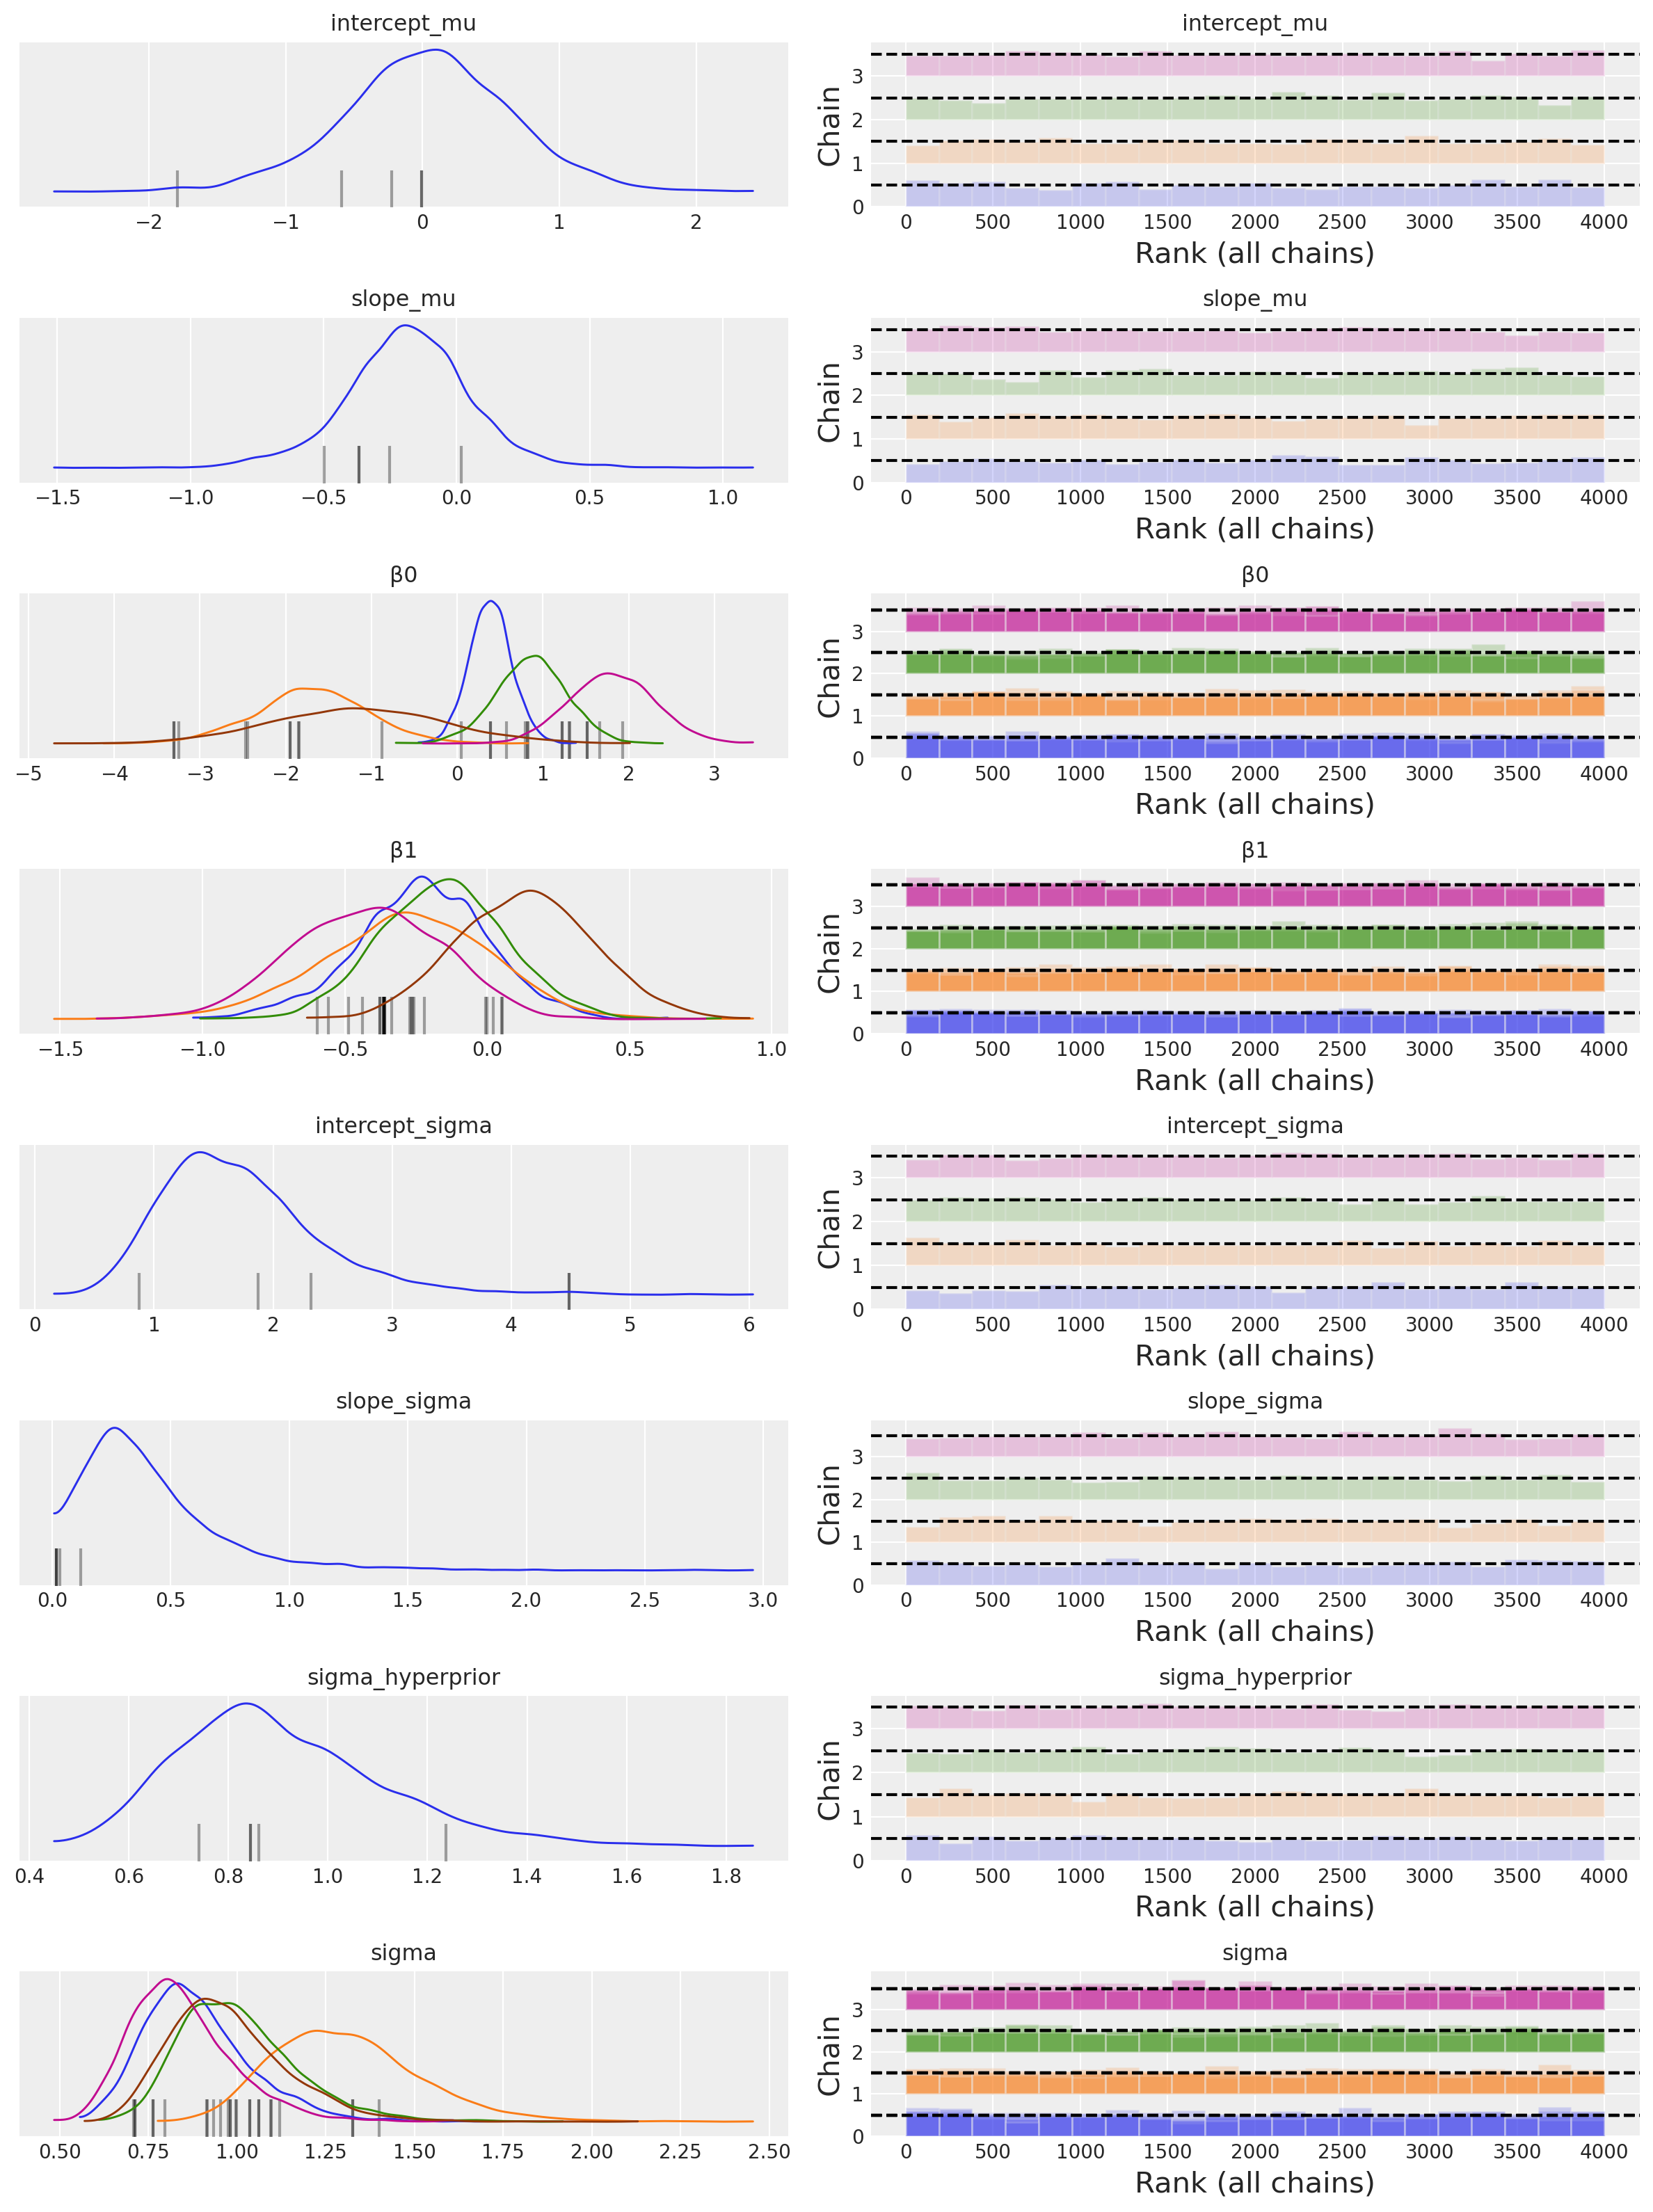

In [28]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

Si noti la presenza di transizioni divergenti.

### Campionamento (con riparametrizzazione)

In [29]:
non_centered = True

with pm.Model(coords=coords) as hierarchical:
    # Hyperpriors
    intercept_mu = pm.Normal("intercept_mu", 0, sigma=1)
    intercept_sigma = pm.HalfNormal("intercept_sigma", sigma=2)
    slope_mu = pm.Normal("slope_mu", 0, sigma=1)
    slope_sigma = pm.HalfNormal("slope_sigma", sigma=2)
    sigma_hyperprior = pm.HalfNormal("sigma_hyperprior", sigma=0.5)

    # Define priors
    sigma = pm.HalfNormal("sigma", sigma=sigma_hyperprior, dims="group")

    if non_centered:
        β0_offset = pm.Normal("β0_offset", 0, sigma=1, dims="group")
        β0 = pm.Deterministic("β0", intercept_mu + β0_offset * intercept_sigma, dims="group")
        β1_offset = pm.Normal("β1_offset", 0, sigma=1, dims="group")
        β1 = pm.Deterministic("β1", slope_mu + β1_offset * slope_sigma, dims="group")
    else:
        β0 = pm.Normal("β0", intercept_mu, sigma=intercept_sigma, dims="group")
        β1 = pm.Normal("β1", slope_mu, sigma=slope_sigma, dims="group")

    # Data
    x = pm.MutableData("x", data.x, dims="obs_id")
    g = pm.MutableData("g", data.group_idx, dims="obs_id")
    # Linear model
    μ = pm.Deterministic("μ", β0[g] + β1[g] * x, dims="obs_id")
    # Define likelihood
    pm.Normal("y", mu=μ, sigma=sigma[g], observed=data.y, dims="obs_id")

In [30]:
with hierarchical:
    idata = pm.sampling_jax.sample_numpyro_nuts(tune=5000, target_accept=0.99)

Compiling...


Compilation time = 0:00:01.009317


Sampling...


  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

  0%|                                                                                 | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                   | 0/6000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 0:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 3:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 2:   0%|                                                                | 0/6000 [00:02<?, ?it/s]

Running chain 3:   5%|██▌                                                 | 300/6000 [00:02<00:03, 1651.80it/s]

Running chain 1:   5%|██▌                                                 | 300/6000 [00:02<00:03, 1626.97it/s]

Running chain 2:   5%|██▌                                                 | 300/6000 [00:02<00:03, 1542.22it/s]

Running chain 0:   5%|██▌                                                 | 300/6000 [00:02<00:05, 1121.66it/s]

Running chain 3:  10%|█████▏                                              | 600/6000 [00:02<00:02, 2117.20it/s]

Running chain 1:  10%|█████▏                                              | 600/6000 [00:02<00:02, 1848.47it/s]

Running chain 2:  10%|█████▏                                              | 600/6000 [00:02<00:02, 1870.24it/s]

Running chain 0:  10%|█████▏                                              | 600/6000 [00:02<00:03, 1556.03it/s]

Running chain 3:  15%|███████▊                                            | 900/6000 [00:02<00:02, 2162.73it/s]

Running chain 1:  15%|███████▊                                            | 900/6000 [00:02<00:02, 1994.01it/s]

Running chain 2:  15%|███████▊                                            | 900/6000 [00:02<00:02, 1947.99it/s]

Running chain 0:  15%|███████▊                                            | 900/6000 [00:03<00:02, 1775.36it/s]

Running chain 3:  20%|██████████▏                                        | 1200/6000 [00:03<00:02, 2128.98it/s]

Running chain 1:  20%|██████████▏                                        | 1200/6000 [00:03<00:02, 2137.74it/s]

Running chain 2:  20%|██████████▏                                        | 1200/6000 [00:03<00:02, 1799.67it/s]

Running chain 0:  20%|██████████▏                                        | 1200/6000 [00:03<00:02, 1958.26it/s]

Running chain 3:  25%|████████████▊                                      | 1500/6000 [00:03<00:02, 2180.24it/s]

Running chain 1:  25%|████████████▊                                      | 1500/6000 [00:03<00:02, 2156.83it/s]

Running chain 0:  25%|████████████▊                                      | 1500/6000 [00:03<00:02, 1933.88it/s]

Running chain 2:  25%|████████████▊                                      | 1500/6000 [00:03<00:02, 1753.50it/s]

Running chain 3:  30%|███████████████▎                                   | 1800/6000 [00:03<00:01, 2106.47it/s]

Running chain 1:  30%|███████████████▎                                   | 1800/6000 [00:03<00:01, 2186.41it/s]

Running chain 3:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:01, 2220.98it/s]

Running chain 0:  30%|███████████████▎                                   | 1800/6000 [00:03<00:02, 1987.91it/s]

Running chain 1:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:01, 2237.25it/s]

Running chain 2:  30%|███████████████▎                                   | 1800/6000 [00:03<00:02, 1766.12it/s]

Running chain 0:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:01, 2120.73it/s]

Running chain 3:  40%|████████████████████▍                              | 2400/6000 [00:03<00:01, 2192.54it/s]

Running chain 1:  40%|████████████████████▍                              | 2400/6000 [00:03<00:01, 2258.61it/s]

Running chain 2:  35%|█████████████████▊                                 | 2100/6000 [00:03<00:02, 1832.85it/s]

Running chain 0:  40%|████████████████████▍                              | 2400/6000 [00:03<00:01, 2143.81it/s]

Running chain 3:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 2204.85it/s]

Running chain 1:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 2162.91it/s]

Running chain 2:  40%|████████████████████▍                              | 2400/6000 [00:03<00:01, 1952.22it/s]

Running chain 0:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 2211.85it/s]

Running chain 3:  50%|█████████████████████████▌                         | 3000/6000 [00:03<00:01, 2182.88it/s]

Running chain 1:  50%|█████████████████████████▌                         | 3000/6000 [00:03<00:01, 2172.97it/s]

Running chain 2:  45%|██████████████████████▉                            | 2700/6000 [00:03<00:01, 1972.71it/s]

Running chain 0:  50%|█████████████████████████▌                         | 3000/6000 [00:04<00:01, 2140.74it/s]

Running chain 3:  55%|████████████████████████████                       | 3300/6000 [00:04<00:01, 2186.91it/s]

Running chain 1:  55%|████████████████████████████                       | 3300/6000 [00:04<00:01, 2065.35it/s]

Running chain 2:  50%|█████████████████████████▌                         | 3000/6000 [00:04<00:01, 1905.46it/s]

Running chain 0:  55%|████████████████████████████                       | 3300/6000 [00:04<00:01, 2148.64it/s]

Running chain 3:  60%|██████████████████████████████▌                    | 3600/6000 [00:04<00:01, 2145.12it/s]

Running chain 1:  60%|██████████████████████████████▌                    | 3600/6000 [00:04<00:01, 1991.25it/s]

Running chain 2:  55%|████████████████████████████                       | 3300/6000 [00:04<00:01, 1873.37it/s]

Running chain 0:  60%|██████████████████████████████▌                    | 3600/6000 [00:04<00:01, 2123.28it/s]

Running chain 3:  65%|█████████████████████████████████▏                 | 3900/6000 [00:04<00:00, 2134.11it/s]

Running chain 1:  65%|█████████████████████████████████▏                 | 3900/6000 [00:04<00:01, 1997.54it/s]

Running chain 2:  60%|██████████████████████████████▌                    | 3600/6000 [00:04<00:01, 1938.93it/s]

Running chain 0:  65%|█████████████████████████████████▏                 | 3900/6000 [00:04<00:00, 2150.44it/s]

Running chain 3:  70%|███████████████████████████████████▋               | 4200/6000 [00:04<00:00, 2150.78it/s]

Running chain 1:  70%|███████████████████████████████████▋               | 4200/6000 [00:04<00:00, 1979.21it/s]

Running chain 2:  65%|█████████████████████████████████▏                 | 3900/6000 [00:04<00:01, 1946.58it/s]

Running chain 0:  70%|███████████████████████████████████▋               | 4200/6000 [00:04<00:00, 2108.08it/s]

Running chain 3:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 2129.04it/s]

Running chain 1:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 1946.13it/s]

Running chain 2:  70%|███████████████████████████████████▋               | 4200/6000 [00:04<00:00, 1983.51it/s]

Running chain 0:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 2129.01it/s]

Running chain 3:  80%|████████████████████████████████████████▊          | 4800/6000 [00:04<00:00, 2137.19it/s]

Running chain 1:  80%|████████████████████████████████████████▊          | 4800/6000 [00:04<00:00, 1995.59it/s]

Running chain 2:  75%|██████████████████████████████████████▎            | 4500/6000 [00:04<00:00, 2053.32it/s]

Running chain 0:  80%|████████████████████████████████████████▊          | 4800/6000 [00:04<00:00, 2092.35it/s]

Running chain 3:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:04<00:00, 2109.74it/s]

Running chain 1:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:05<00:00, 1935.00it/s]

Running chain 2:  80%|████████████████████████████████████████▊          | 4800/6000 [00:05<00:00, 1949.47it/s]

Running chain 0:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:05<00:00, 2001.91it/s]

Running chain 3:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:05<00:00, 2027.69it/s]

Running chain 1:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:05<00:00, 2028.78it/s]

Running chain 0:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:05<00:00, 2079.75it/s]

Running chain 2:  85%|███████████████████████████████████████████▎       | 5100/6000 [00:05<00:00, 1957.82it/s]

Running chain 3:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2069.77it/s]

Running chain 1:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2109.09it/s]

Running chain 0:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2154.04it/s]

Running chain 2:  90%|█████████████████████████████████████████████▉     | 5400/6000 [00:05<00:00, 2034.73it/s]

Running chain 3: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 2068.30it/s]

Running chain 1: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 2211.01it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 2220.50it/s]

Running chain 2:  95%|████████████████████████████████████████████████▍  | 5700/6000 [00:05<00:00, 2153.02it/s]

Running chain 2: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 2264.10it/s]

Running chain 0: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1078.75it/s]


Running chain 1: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1078.94it/s]


Running chain 2: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1079.21it/s]


Running chain 3: 100%|███████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1079.48it/s]


Sampling time = 0:00:05.682790


Transforming variables...


Transformation time = 0:00:00.124430


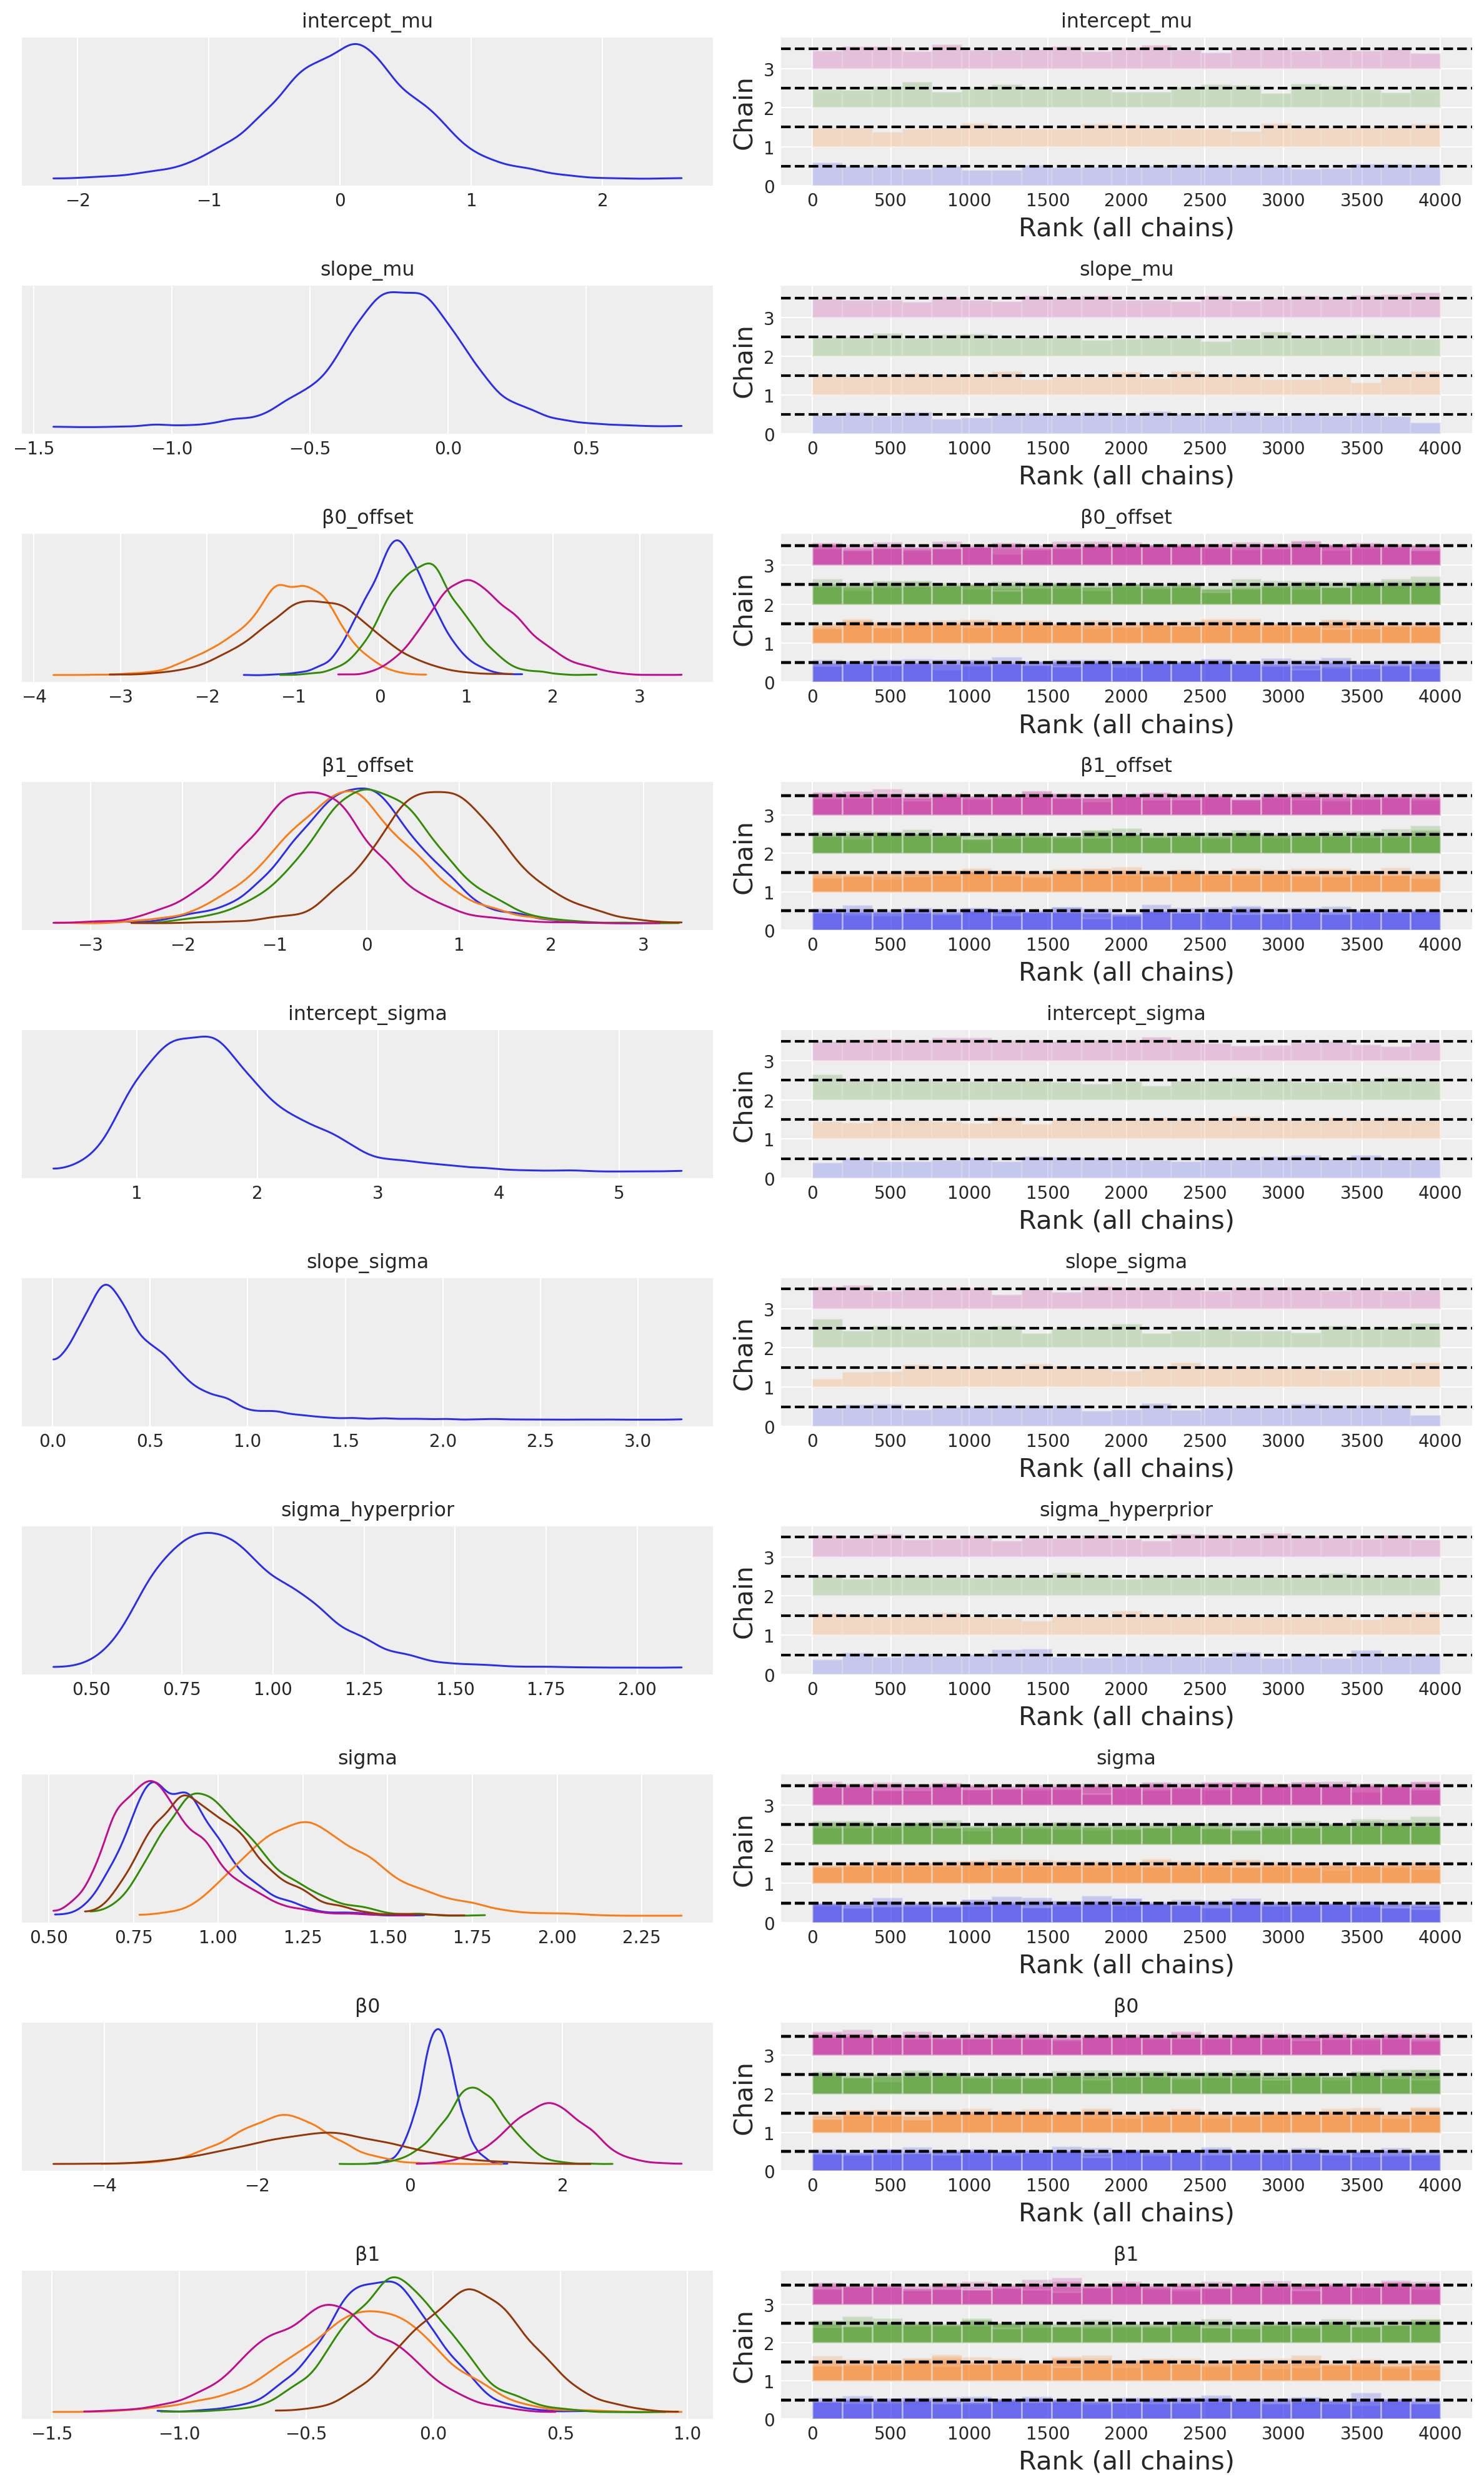

In [31]:
az.plot_trace(
    idata,
    combined=True,
    filter_vars="regex",
    var_names=["~μ"],
    kind="rank_bars",
    divergences="bottom",
)
plt.tight_layout()

Si noti che non vi sono più transizioni divergenti.

### Visualizzazione

In [32]:
# Create values of x and g to use for posterior prediction
xi = [
    np.linspace(data.query(f"group_idx=={i}").x.min(), data.query(f"group_idx=={i}").x.max(), 10)
    for i, _ in enumerate(group_list)
]
g = [np.ones(10) * i for i, _ in enumerate(group_list)]
xi, g = np.concatenate(xi), np.concatenate(g)

# Do the posterior prediction
with hierarchical:
    pm.set_data({"x": xi, "g": g.astype(int)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["μ", "y"]))

Sampling: [y]


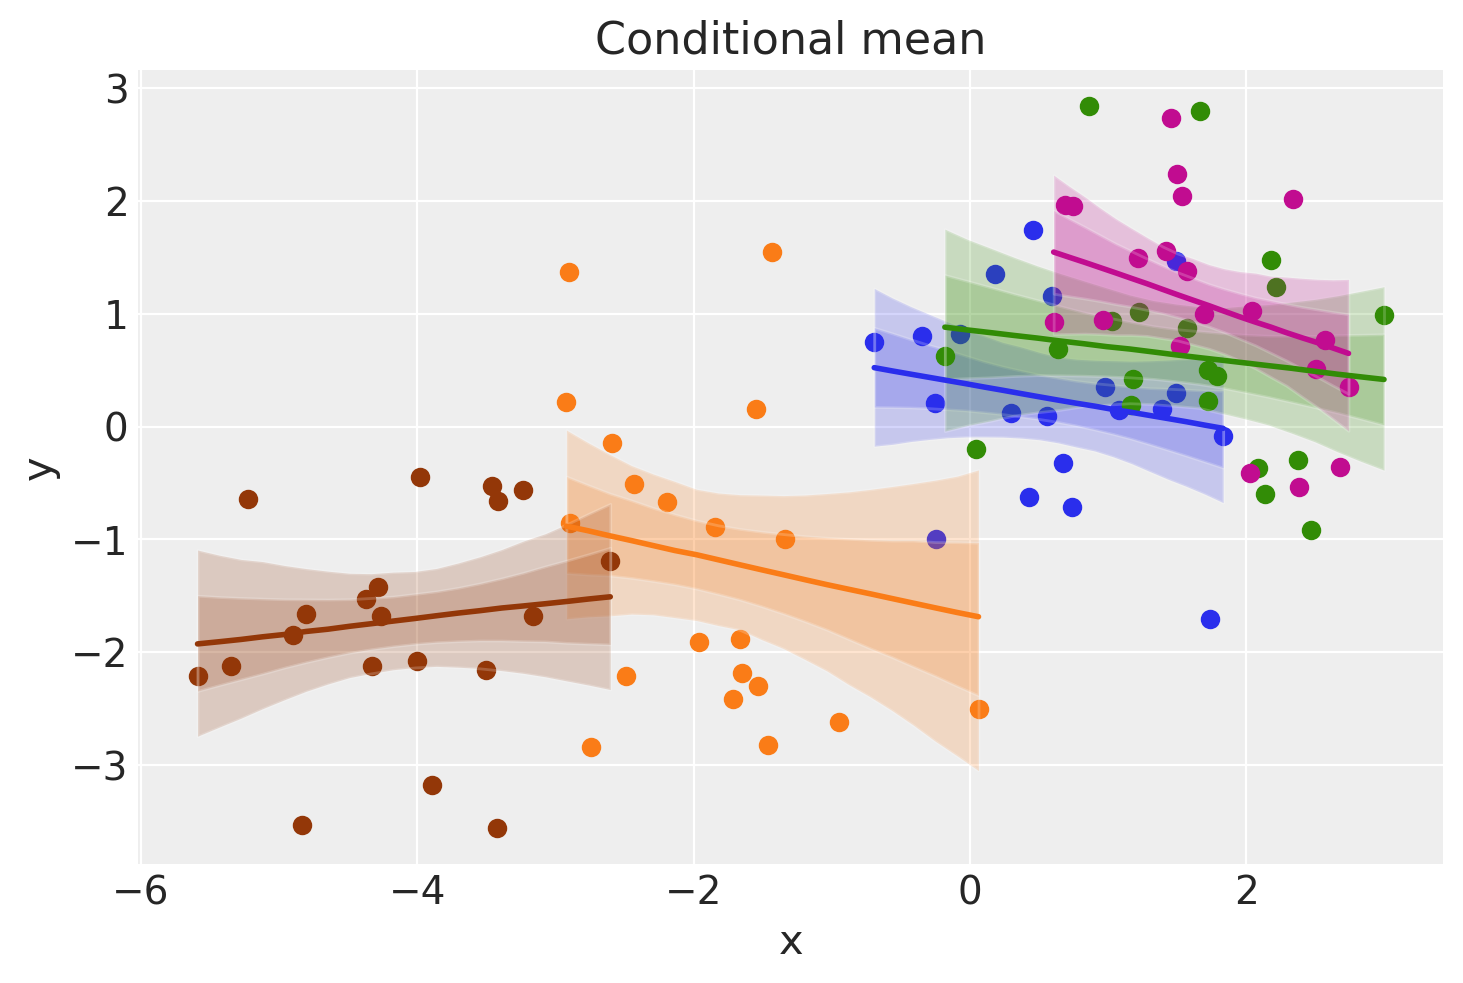

In [33]:
fig, ax = plt.subplots(1, 1)

# conditional mean plot ---------------------------------------------
for i, groupname in enumerate(group_list):
    # data
    ax.scatter(data.x[data.group_idx == i], data.y[data.group_idx == i], color=f"C{i}")
    # conditional mean credible intervals
    post = az.extract(idata)
    _xi = xr.DataArray(
        np.linspace(np.min(data.x[data.group_idx == i]), np.max(data.x[data.group_idx == i]), 20),
        dims=["x_plot"],
    )
    y = post.β0.sel(group=groupname) + post.β1.sel(group=groupname) * _xi
    region = y.quantile([0.025, 0.15, 0.5, 0.85, 0.975], dim="sample")
    ax.fill_between(
        _xi,
        region.sel(quantile=0.025),
        region.sel(quantile=0.975),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    ax.fill_between(
        _xi,
        region.sel(quantile=0.15),
        region.sel(quantile=0.85),
        alpha=0.2,
        color=f"C{i}",
        edgecolor="w",
    )
    # conditional mean
    ax.plot(_xi, region.sel(quantile=0.5), color=f"C{i}", linewidth=2)
    # formatting
    ax.set(xlabel="x", ylabel="y", title="Conditional mean")


La figura mostra la distribuzione a posteriori di gruppo dei parametri di pendenza e intercetta. Tuttavia, questa particolare visualizzazione risulta poco chiara, quindi possiamo semplicemente tracciare la distribuzione marginale della pendenza a livello di popolazione per vedere quanto sia fondata la credenza che tale pendenza sia minore di zero.

In [34]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Text(0.5, 1.0, 'Population level slope parameter')

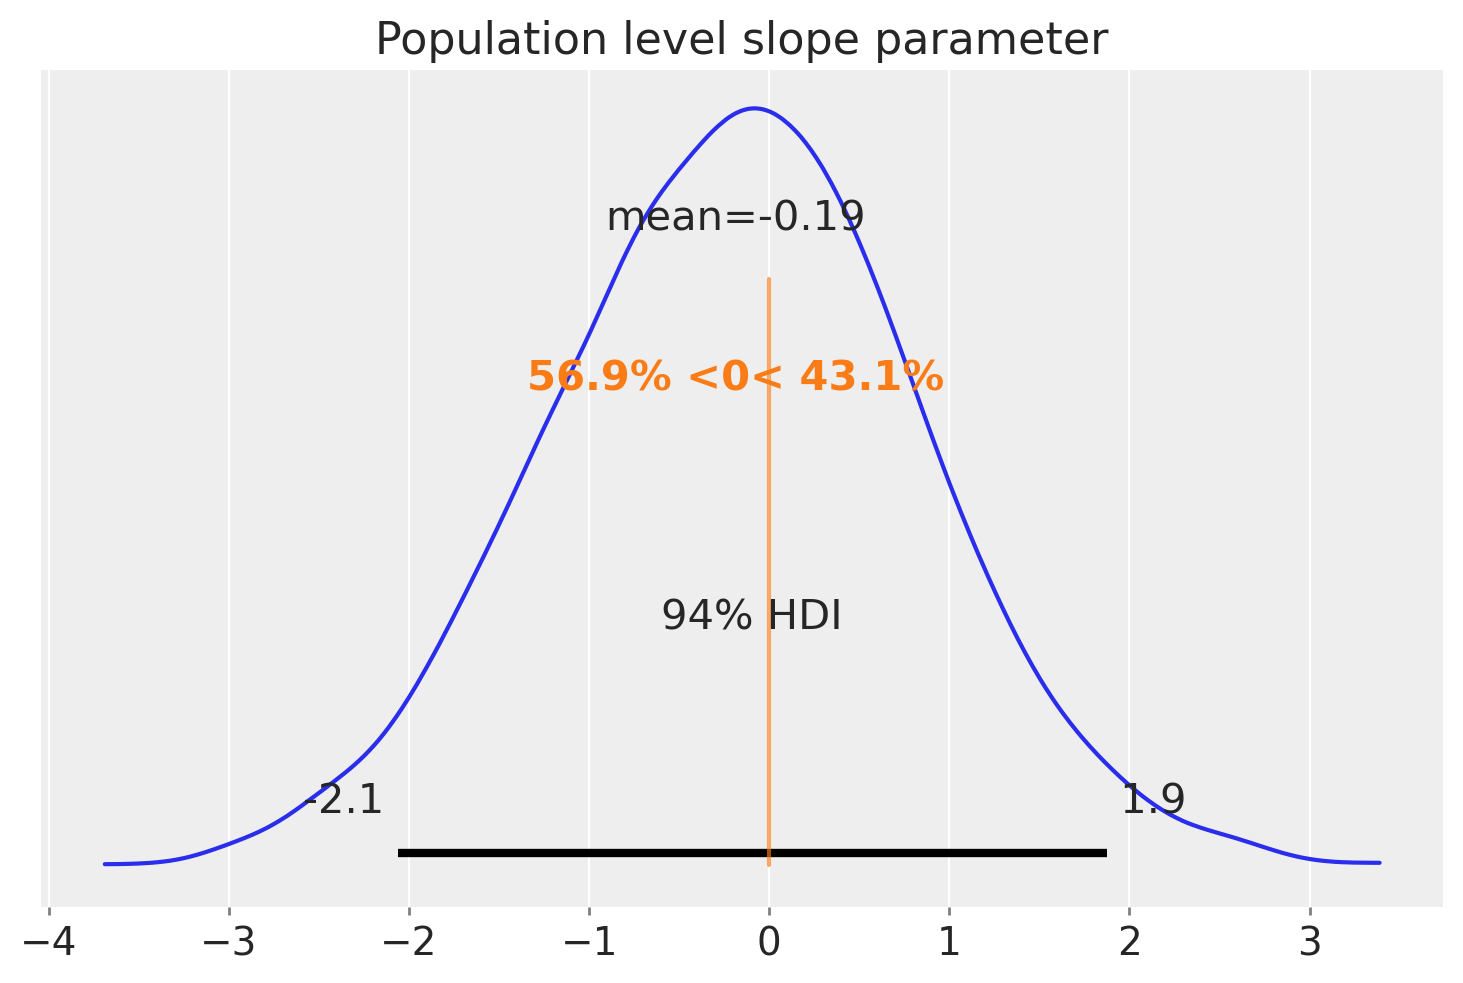

In [35]:
# plot posterior for population level slope
slope = rng.normal(az.extract(idata.posterior, var_names="slope_mu"))
az.plot_posterior(slope, ref_val=0)
plt.title("Population level slope parameter")

Si osserva che, analizzando i dati a livello di popolazione attraverso un approccio che tiene in considerazione la struttura gerarchica dei dati, non emerge alcuna evidenza  di una associazione lineare tra le due variabili in questione; il coefficiente $\beta_1$ è pari a -0.44 con un intervallo di credibilità al 94% che va da -2.6 a 1.4. Questo risultato contraddice le conclusioni tratte dall'analisi condotta sui dati aggregati, indicando l'assenza di una relazione tra le variabili a livello di popolazione.

## Commenti e considerazioni finali

Utilizzando il paradosso di Simpson, abbiamo esaminato tre modelli differenti. Il primo è una semplice regressione lineare che tratta tutti i dati come provenienti da un unico gruppo. Abbiamo visto che ciò ci ha portato a credere che la pendenza della regressione fosse positiva.

Sebbene ciò non sia necessariamente sbagliato, è paradossale quando osserviamo che le pendenze delle regressioni per i dati all'interno di un gruppo sono negative. Nel secondo modello, abbiamo visto come applicare regressioni separate per i dati in ogni gruppo.

Il terzo e ultimo modello ha aggiunto un ulteriore livello alla gerarchia, catturando la nostra consapevolezza che ciascuno di questi gruppi è campionato da una popolazione generale. Questo ha aggiunto la capacità di fare inferenze non solo riguardo i parametri di regressione a livello di gruppo, ma anche a livello di popolazione. L'ultimo grafico mostra la nostra distribuzione a posteriori su questo parametro di pendenza a livello di popolazione, da cui crediamo che i gruppi siano campionati.

## Watermark

In [36]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Wed Nov 15 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.17.2

pandas    : 2.1.3
seaborn   : 0.13.0
arviz     : 0.16.1
scipy     : 1.11.3
pymc      : 5.9.2
numpy     : 1.25.2
xarray    : 2023.10.1
matplotlib: 3.8.1

